<center><span style="color:#606c38;font-weight:700;font-size:15px;">

# Political Tweet and Bot Classifier - Turkish Politics
</span></center>
<center><span style="color:#AE2012;font-weight:700;font-size:15px;">
</span></center>

<center><span style="color:#023047;font-weight:700;font-size:15px;">

</span></center>



<center><span style="color:#606c38;font-weight:700;font-size:15px;">
Description
    </span></center>

<span><center> The present project aims to address two pressing issues in the context of Turkish Twitter: the proliferation of political content and the prevalence of bot accounts. Utilizing advanced machine learning techniques, the project seeks to classify political tweets and distinguish between genuine user accounts and bots. The project is being undertaken as part of the Machine Learning course offered by Dr. Onur Varol at Sabancƒ± University, with the ultimate goal of contributing to a deeper understanding of these issues and their impact on online discourse in Turkey.

In [ ]:
from datetime import datetime as dt
from collections import Counter
import os, sys, glob
import pandas as pd
import numpy as np
import random
import gzip  
import tqdm
import json

pd.set_option("display.max_columns", None)

from matplotlib import pyplot as plt
from IPython import display
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb

%matplotlib inline
%load_ext autoreload
%autoreload 2


<center><span style="color:#606c38;font-weight:700;font-size:15px;">
Feature Extraction
    </span></center>

Under *1.1. Political Tweet Detection* and *1.2. Bot Detection*, we firstly collect raw data for processing. We then combine some of them (total_interactions = num_favorites + num_retweets) or use them to extract features (whether the tweet has one of the political entities @meralaksener, @kilicdarogluk etc.).

This section shows how to create a dataframe over the Twitter metadata using the created features. You can review the data generated as a result of this section in the GitHub repository and use it in your studies. Also, if you have a raw data set and want to use the features we extracted, you can upload your metadata and get the data.

## 1.1. Political Tweet Detection


### 1.1.1. Get Raw Data

#### 1.1.1.1. Check if Retweet

In [ ]:
def check_if_retweet(tweet_metadata_line):
    is_retweet = 0
    retweeted_username = "None"

    try:
        tweet_metadata_line['retweeted_status']
        retweeted_username = tweet_metadata_line['retweeted_status']['user']['screen_name'].lower()
        is_retweet = 1

    except KeyError:
        pass

    return is_retweet, retweeted_username

#### 1.1.1.2. Get Tweet Text

In [ ]:
def get_tweet_text(tweet_metadata_line):
    text = tweet_metadata_line['text']
    
    return text

#### 1.1.1.3. Get Tweet ID

In [ ]:
def get_tweet_id(tweet_metadata_line):
    id_str = tweet_metadata_line['id_str']
    
    return id_str

#### 1.1.1.4. Get Number of Mentions and Hashtags

In [ ]:
def get_number_mentions_hashtags(tweet_metadata_line):
    num_mentions = len(tweet_metadata_line['entities']['user_mentions'])
    num_hashtags = len(tweet_metadata_line['entities']['hashtags'])

    return num_mentions, num_hashtags

#### 1.1.1.5. Get Number of Retweets and Favorites

In [ ]:
def get_number_retweets_favorites(tweet_metadata_line):
    retweet_count = tweet_metadata_line['retweet_count']
    favorite_count = tweet_metadata_line['favorite_count']
    
    return retweet_count, favorite_count

#### 1.1.1.6. Get User Info

In [ ]:
def get_user_info(tweet_metadata_line):
    id = tweet_metadata_line['user']['id_str']
    screen_name = tweet_metadata_line['user']['screen_name'].lower()
    description = tweet_metadata_line['user']['description']

    return id, screen_name, description

### 1.1.2. Derive Manually Crafted Features

#### 1.1.2.1. Check for political entity in text

In [ ]:
def check_political_ent(text):
    # the list below can be modified and some new names may be added (or removed). Following usernames are the politicians in Turkey.
    list_of_entities = ['RTErdogan', 'BY', 'NumanKurtulmus', 'Hayati_Yazici', 'erkankandemir',         'aliihsanyavuz54', 
'avhamzadag', 'efkanala', 'jsarieroglu', 'mehmetozhaseki',         'nurettincanikli', 'AvOzlemZengin', 'leylasahinusta', 
'vedatdemiroz', 'CK_Samsun',         'mustafasenbd', 'DrOmerileri', 'omerrcelik', '_fatihsahin', 'aysekesir', 
'eyupkadirinan',         'kilicdarogluk', 'ahmetakin', 'ali_oztunc', 'bkusoglu', 'bulenttezcanchp', 'faikoztrak',         
'FethiAcikel', 'gamzeilgezdi', 'GokceGokcen_', 'GulizarBicer', 'lalekarabiyik',         'muharremerkek17', 'oguzksalici', 
'onursaladiguzel', 'selinsayekboke', 'seyit_torun',         'veliagbaba', 'yukseltaskinn', 'alibabacan', 'birolaydemir15', 
'yaseminbilgel1', 'bdalgin',         'emin_ekmen', 'mustafaergen_', 'erginsadullah', 'elifesendeva', 'helunfirat', 
'hasankaraltr',        'c_karlitekin', 'sanemoktar', 'hatipoglupaysun', 'rizvanogluevrim', 'avidrissahin',         
'dogasanlioglu', 'mustafaucak07', 'nazlisedavural', 'myeneroglu', 'medeniylmz',         'Ahmet_Davutoglu', 'mnedimyamali', 
'SelimTemurci', 'AyhanSeferUSTUN', 'dogandemir41',         'FeridunBilgin64', 'selcukozdag', 'abdullahbasci', 'kerimrota', 
'mustafamente', 'SerapProf',        'AliPulcu', 'umityardim1961', 'SemaSilkin', 'Hbb_Ciftcioglu', 'BMustafaGozel',         
'feramuzustun', 'torunkani', 'serkanozcan1', 'hdpdemirtas', 'figenyuksekdag', 'pervinbuldan',         'mithatsancarr', 
'ayseacar_b', 'av_ebrugunay', 'Feleknasuca', 'GaroPaylan', 'SaruhanOluc',         'ilknur_Birol', 'GuleryuzMahfuz', 
'meraldanis', 'musaproglu', 'sonmeznaci', 'salimkaplanhdp',        'drsametmenguc', 'sultanozcan38', 'saziyekose59', 
'TayipTemel', 'tuncerbakirhan',         'UmutDede16', 'velisacilik', 'YunusPARIM', 'meral_aksener', 'korayaydintr', 
'UGUR__POYRAZ',         'UmitDikbayir', 'BBahadirErdem', 'senolsunat', 'Ahmet_Erozan', 'ridvanuz17',         'SalimEnsarioglu', 
'MetinErgun48', 'ProfBilgeYilmaz', 'avtolgaakalin', 'UmitOzlale',         'SevincAtabay', 'avunzileyuksel', 'Akburak', 
'vekilince', 'dbdevletbahceli',         'E_SemihYalcin', 'yildizfeti', 'mkalayci42', 'ifarukaksu', 'ismailozdemirrr',         
'KarakayaMevlut', 'kamilaydinmhp', 'UlviYonter', 'sadirdurmaz', 'drpelinyilik',         'yasaryldrmmhp', 'buyukataman', 
'prfdrfilizkilic', 'tmrosmanagaoglu', 'bbbozarslan',        'umitozdag', 'herkesicinchp', 'adem__taskaya', 'alidincercolak', 
'sevdagultuncer', 'bartusoral', 'ayhanturkz',        'cezmi_polat', 'tugrulk_zaferp', 'draslanyaman', 'feridunyildiz', 
'BayirFikret', 'AyanGurol',        'ismail_turk55', 'KocakTukenmez', 'lutfusahsuvar', 'muratozgur2001', 
'kaptmustafacan',         'sagaltun', 'sedattimur161', 'sevdaozbk', 'seyityucel06', 'TCKayalak', 'ugurbaturr',         
'06melihgokcek', 'meral_aksener', 'osmannnurika', 'akaraismailoglu', 'varank',         'fahrettinaltun', 'deryayanikashb', 
'ayyildirim1', 'RTErdogan', 'mansuryavas06',         'ekrem_imamoglu', 'fuatoktay', 'FatmaSahin', 'drfahrettinkoca', 
'ikalin1',         'Canan_Kaftanci', 'tuncsoyer', 'senerabdullatif', 'korayaydintr', 'ilhankesici',         'samilayrim', 
'AhatAndican', 'EToprakCHP', 'Dr_Demircan', 'bedriyasartr',         'kemalcelik007', 'celal_adan', 'ihaliloral', 'Mbekaroglu', 
'cenginyurt52',         'dbdevletbahceli', 'CulhaMetanet', 'MetinErgun48', 'nurettincanikli',         'kilicdarogluk', 
'Hayati_Yazici', 'enginaltaychp', 'yasartuzun06', 'Akif_Hamzacebi',         'profdrhalukkoc', 'recepozel32', 'zulfudemirbag23', 
'BattalFetani', 'Bayramburdur',         'polatturkmen67', 'turan_haci', 'DrMehdiEker', 'ramazancan0071', 
'FeyziBerdibek1',         'ahmet_uzer27', 'mustafaatas', 'fahricakir81', 'MevlutCavusoglu', 'bybekirbozdag', 'BY',         
'ismailbilen45', 'Vahit_Kiler', 'oerdem42', 'mustafaelitas', 'DrRecepAkdag',         'HakkiKoylu37', 'yilmaz_ismet58', 
'TugrulTurkes', 'sdbilgic32', 'TekinBingolCHP',         'tasar_cemal', 'senolsunat', 'faikoztrak', 'muharremvarli01', 
'lutfielvan', 'buyukataman',         'erkanakcay45', 'MKalayci42', 'fkurtulan33', 'PervinBuldan', 'mehmeterdogan27', 
'fikriisik',         'yilmaztunc', 'behiccelik', 'VeyselEroglu', 'cumhurunal7806', 'IlknurInceoz', '_cevdetyilmaz',         
'AhmetAYDIN_02', 'oznurcalik', 'canankalsin', 'alev_dedegil', 'ahmetsalihdal', 'ackilic76',         'LutfuTurkkan', 
'ekremcelebi4', 'nacibostanci', 'halilozcan63', 'haydarakar',         'drorhanatalay56', 'Y_Akdogan', 'tanjuozcanchp', 
'goklevent', 'yunuskilic36', 'ahmetarslan36',         'emrullahisler', 'avyusufbaser', 'bkusoglu', 'gulaysamanci42', 
'E_SemihYalcin',         'Ziverozdemir', 'bulenttezcanchp', 'HBTurkoglu', 'aykuterdogdu', 'fehmikupcu14',         
'vedatdemiroz', 'SerminBalik23', 'nejatkocer', 'Mtanal', 'deryabakbak27', 'ismailgunes64',         'AliSahin501', 
'turanbulent', 'mehmedmus', 'TCAytunCiray', 'mehmetaltay64', 'enginozkoc',         'mdogankubat', 'AvTufanKose', '_fatihsahin', 
'aliihsanyavuz54', 'SIRIN_UNAL', 'gurseltekin34',         'CandanYceer', 'Hakan_cavusoglu', 'OA_Bak', 'MSErdinc', 
'sadirdurmaz', 'veliagbaba',         'mahirunal', 'Belmasatir', 'volkan_bozkir', 'avhamzadag', 'erolkaya_ist', 
'OsmanBoyraz',         'beratconkar', 'osman_oren', 'MustafaSentop', 'MSTanrikulu', 'UgurBayraktutan',         'tulaykaynarca', 
'uguraydemir45', 'eczozgurozel', 'eronat_oya', 'ilyasseker41',         'mvitamer', 'ismetUcma', 'NumanKurtulmus', 'umitozdag', 
'drrecepseker',         'DurmusYillmaz', 'AvUnaldemirtas', 'bkaradeniz57', 'drmehmet_goker',         'abdurrahmanbask', 
'CetinOsmanBudak', 'muratemirchp', 'kamilaydinmhp', 'ahhakverdi',         'seferaycan', 'avaliozkaya', 'mdurmusoglu', 
'avmetincelik', 'ozkan_yalim', 'leylasahinusta',         'ZiyaAltunyaldiz', 'av_ishakgazel', 'BaybaturMurat', 'tcbuyuksehir', 
'_ibrahimaydemir', 'kulmustafa77_ac',         'muhammetbalta61', 'adnangunnar', 'suleymansoylu', 'VecdiGundogdu', 
'ali_ihsanarslan',         'Av_Burcu03', 'Seyit_TORUN', 'drmadiguzel', 'erdinbircan', 'agral_abdullah', 'haozdemir',         
'uncuoglurecep', 'ZTaskesenlioglu', 'halisdalkilic', 'ImamTascier', 'haliletyemez',         'DrRidvanTuran', 'okangaytanciogl', 
'aysekesir', 'saffetsancakli', 'KarakayaMevlut',         'TurabiKayan', 'GulizarBicer', 'AvHalilFirat', 'myeneroglu', 
'ChpNihatYesil', 'arzuerdemDB',        'utkucakirozer', 'ahmetakin', 'ifarukaksu', 'Emine_Gozgec16', 'selvacam', 
'abdulhamitgul',         'MustafaYel59', 'aefakibaba', 'EnisBerberoglu1', 'DrCetinArik', 'tahsintarhan',         
'bakisimsekmhp', 'fatmakaplan', 'alikenanoglu', 'erkankandemir', 'ayhanbilgen',         'akbasogluemin', 'NevzatCeylan06', 
'HdpGaydali', 'hisyarozsoy', 'jsarieroglu',         'UlviYonter', 'selinsayekboke', 'mithatsancarr', 'SezaiTemelli', 
'oguzksalici',         'ZeynelEmre_', 'serkantopalchp', 'AvOzlemZengin', 'dilan_dirayet', 'berdan_ozturk',         
'ayseacar_b', 'onlu_alican', 'Feleknasuca', 'sezerkatirciogl', 'MuharremErkek17',         'ATuncayOzkan', 'HudaKaya777', 
'nimetullah__e', 'kazimarslan20', 'tacettinbayir',         'FuatKoktas55', 'nurhayataltaca', 'mvhuseyinyildiz', 
'KemalZeybek55', 'ismailok_',         'eminsimsekmus', 'Mustafa_CHP', 'ozcanpurcu', 'lalekarabiyik', 'togrularya', 
'erkanecz',         'CK_Samsun', 'bulenttufenkci', 'LeylaGuvenkcd', 'meraldanis', 'FilizKer', 'GaroPaylan',         
'orhansaribalchp', 'kamilsindir', 'HuseyinYayman', 'onursaladiguzel', 'metinbulut23',         'gamzeilgezdi', '55erhanusta', 
'draliseker', 'mehmetozhaseki', 'avmustafakose', 'ABabuscu',         'markaresayan', 'RavzaKavakci', 'MAkifYilmaz42', 
'Selami__Altinok', 'AhmetSCeylan',         'cihanpektas1', 'cengizaydogdu_', 'HaberalErkan', 'osmanakgul29', 
'celalettingvnc',         'dr_sozdemir', 'serapyahsiyasar', 'iekarayel', 'NergisAtci', 'erguntasci52', 'metingunordu',         
'AtillaSertell', 'av_ihalilyildiz', 'malicevheri', 'fethigurer', 'hasanturantr',         'sorgunahmet', 'CHPMuratBakan', 
'scakir20',  'cemil_yaman', '07ibrahimaydin', 'Tamer_Dagli',         'NazimMavis', 'Hilmi_Dulger79',  'ozturkyilmazYP', 
'ahmettan43',         'haciozkan33', 'MAtillaKaya', 'AvSerkanBayram',         'mvcemalozturk', 'AvSabriOzturk', 
'ahmethamdicamli', 'atayuslu', 'sahin_tin', 'avcahitozkan',        'AvOrhanKIRCALI', 'kadimdurmaz', 'gurselerol62', 
'alicumhurtaskin', 'yusufbeyazit60',         'aydinmsavas', 'harun_karacan', 'EmineNurGunay', 'mufitaydin16', 
'ebubekirbal_',         'SMinsolmaz', 'bediaozgokce', 'imranmkilic2023', 'ceydabc47', 'corasalih', 'drbetulsayan',         
'osmanmesten16', 'scivitcioglu', 'CilezHasan', 'akadirkaraduman', 'SermetAtay',         'ArkazHayati', 'drtasdogan', 
'muhammedavci53', 'mhpesinkara', 'mlkarahocagil',         'fahrettinyokus', 'yclblt06', 'avzeynepgul', 'hakansidali', 
'Avkthalilozturk',         'mnsazak', 'faruk_sariaslan', 'ahmetozyurekmhp', 'mutlaydemir', 'adil_celik10',         
'yavuzsubasi', 'belginuygur10', 'MustafaCanbey', 'gulenderacanal', 'a_kabukcuoglu',         'dryukselozkan', 'jalenursullu', 
'ali_oztunc', 'rizgin__birlik', 'mustafa_destici',         'gamzetascier', 'yildirimkaya40', 'avtutdere', 'drmetinilhan40', 
'yasaryldrmmhp',         'onalahmet71', 'mvkadiraydin', 'ozboyaciselman', 'cengizdmrky47', 'seyhmusdincel47',         
'toprak_av', 'yakuptas02', 'ay_altintas', 'nevintaslicay', 'habibeocal46', 'mcihatsezal',         'avahmetozdemir', 
'kayaismail80', 'bahaunluchp', 'abuyukgumus', 'irfankaplanchp',         'ozcanozel_', 'prhasankalyoncu', 'mehmettaytakmhp', 
'mhrpolat', 'fikretsahin10',         'yzyilmaz55', 'avyurdunuseven', 'hasanbaltacichp', 'drservetunsal', 
'e_erkanbalta',         'barisaydin06', 'dr_h_avniaksoy', 'eyupozsoymv', 'senelyediyildiz', '24burhancakir',         
'suleymankrmn', 'cengiz_gokcel', 'oyaersoy', 'tatliogluismail', 'tahir_akyurek',         'gokanzeybekchp', 'OzgurKarabatCHP', 
'alimahir', 'ozturkdenizli', 'nacicinisli',         'mguzelmansurchp', 'tokdemirismet', 'ErolKAVUNCU', 'avoguzhankaya', 
'm_levent_bulbul',         'mbulentkaratas', 'ilhamiozcanaygn', 'mucahitarinc', 'alpayozalan35', 'kanibekochp',         
'ednanarslanchp', 'fazilkasap', 'sevdaerdan', 'avSelmanEser', 'ahmetcolakoglu0',         'satiroglu2018', 'hamdiucar67', 
'UmitDikbayir', 'mustafademir', 'ahmetcelikycag',         'yukselmuslum27', 'iffetpolat', 'msaitkirazoglu', 'esarea', 
'kaplanenez', 'bakiersoymhp',         'mugokgoz32', 'h_nuhoglu', 'orhanyegin', 'ramazannkasli', 'AAsumanErdogan',         
'SirakayaZafer', 'mdervisoglutr', 'yildizfeti', 'azizaydinlikchp', 'osmangulacartr',         'selimyagci11', 'yukselmkilinc', 
'ProfDrFiliz', 'zaferisik016', 'yasarkirkpinarr',         'cccemalcetin', 'abdulkadirozl', 'hsanverdi', 'sabahatozgursoy', 
'avukatayhanerel',         'yavuzagiraliog', 'avmustafaarslan', 'baharayvazoglu', 'fatmaaksal', 'mustafaesgin016',         
'HVahapoglu', 'atillaodunc16', 'hasan_subasi', 'yasinugurmv', 'abdullahdogru01',         'gergerliogluof', 'mvyavuzergun', 
'ceydaerenler', 'selimgultekn51', 'semihaekinci58',         'feridun_bahsi', 'refik_ozen16', 'h_ahmet_kilic', 
'vildanylmzgurel', 'mhpyasarkaradag', 'ikoncuk', 'aysesibelersoy', 'avantmen33', 'yunusemrechp', 'suzansahin1881', 
'sahmetsahmet', 'ahmeterbas43', 'dursunatas38', 'rafet_zeybek', 'selcukmizrakli', 'kemalpekoz', 'tmrosmanagaoglu', 
'perodundar', 'AyseSurucuUrfa', 'yavuzyilmazd', 'AvTuranAydogan', 'TulayHatim', 'ArvasAbdulahat', 'unalcevikoz', 
'orhancakirlar22', 'Sdk56hdp', 'ahmetakayurfa', 'ahmetcakir44', 'hkahtal', 'avsbulbul', 'apolatduzgun',         'omerrocalan', 
'zyildiz_', 'zeynelozenhdp', 'dilsatcanbaz', 'zuleyhagulum', 'TayipTemel', 'aysubankoglu', 'ensaraytekin10', 'Hasanozgunes1', 
'av_ebrugunay', 'DrHabip',         'nusrettin_macin', 'rumeysakadak', 'umitbeyaz34', 'ar_aydn', 'cesuraylin', 'ahmetkayachp', 
'murselalban', 'mvsuatozcan', 'ntigli28', 'MehmetYavuzDem3', 'ahmet_erozan',         'AyhanBarut01', 'husretdinc30', 
'eczumityilmaz', 'ismailozdemirrr', 'nuran_imir', 'avhuseyinkacmaz', 'orhanssumer', 'IpekyuzNecdet', 'tuma_celik', 
'polatsaroglu', 'ethemsedef', 'RemziyeTosunHDP', 'semraguzelhdp', 'MuratCepniHDP', 'serpilkemalbay', 'eczburhan', 
'avmensurisik', 'emecangulizar', 'basevirgenbekir', 'teomansancar20', 'avbakirlioglu', 'aydinasezgin', 'lutfikasikci', 
'Muazzezorhn', 'mzyensevkin', 'ckoncagul', 'neslihancioglu', 'glstnkocyigit', 'chpatakanunver', 'ahmetzenbilci', 'a_yildiz_', 
'Nilgun_OK', 'sgirgin48tbmm', 'bedriserterchp', 'muratsarisac', 'erkbas', 'm_farisogullari', 'celebimehmeta', 'dersimdag21', 
'DrSaitDede', 'sevincoskun_', 'metinyavuz009', 'bekirkuvveterim', 'abdullahkochdp', 'mv_cavitari', 'rizaposaci', 'necipnasir', 
'irfankartal_65', 'avabdullahguler', 'eminezeybek_mv', 'yucelmenekse50', 'ibrahimkaboglu', 'cigdematabek', 'serakadigil', 
'melihaakyol77', 'Cbekle', 'OlcayKilavuz', 'vekilyilmazkaya', 'musaproglu', 'DpGultekinUysal', 'skaplankivircik', 
'ozgurceylanchp', 'zulfutolgagar', 'yeldagokcan', 'ozkanmehmetali', 'iozyavuz1963', 'cihangirislam', 'jiskenderoglu', 
'aydinozer07', 'tubavuralcokal', 'barisatay', 'ErolKat', 'averdalaydemir', 'burakerbaychp', 'alikevenyozgat', 'ulasskarasu', 
'mhabibsoluk', 'efkanala', 'uzancc', 'T_Karamollaoglu', 'LeventTuzel', 'AbdullahZeydan', 'A_Boynukalin', 'AbdurrahmanOz09', 
'akgulkadir66', 'ademyesildal', 'AdnanBoynukara', 'adnanyilmaz_', 'cirkinoglu', 'AhmetMisbah', 'ahmetgundogdu01', 
'akenantanrikulu', 'ahmet__yurdakul', 'ahmetyildirihdp', 'ahmet_iyimaya', 'aknustundag48', 'alev_dedegil', 'AliAkyildiz58', 
'AliAtalan68', 'AydinliogluA', 'AliErcoskun', 'ahhakverdi', 'AliHaydarKonca', 'AliUzunirmak', 'aliozmersin', 'chpaliozcan', 
'aliinci54', 'AlimISIK', 'Adursun15', 'alp_kavaklioglu', 'AltanTan1958', 'asiyekolcakhdp', 'aslansavasan', 'AtilaKaya_MHP', 
'aycanirmez', 'auslupehlivan01', '_aydinunal', 'ayhanbilgen', 'ayhanyilmaz06', 'AylinNazliaka', 'aytugatici', 'dtaysedogan', 
'GBilgehan', 'aysesula', 'aysenurlslam', 'bakisimsekmhp', 'bkaradeniz57', 'barisyarkadas', 'yildirimbehcet', 'BKaraburun', 
'BihlunTamaylgil', 'UcarBilal20', 'CHPbirolertem', 'avburcucelik', 'Burhan_Kayaturk', 'BulentBelen59', 'bulenttufenkci', 
'bybektasoglu', 'CHPBulentOz', 'cahitbagci', 'CananCCelik', 'CDaggez', 'celaldgn2727', 'celilgocer', 'cemalokanyuksel', 
'cemalettin_kafl', 'torunkani', 'cemil_seboy', 'CengizTokmak', 'ceyhunirgil', 'coskuncakir60', 'dengirmir1', 'chpdevrimkok', 
'_DidemEngin', 'OcalanDilek', 'dilan_dirayet', 'Aliskaya',         'dfikrisaglar', 'yalcin0634', 'drdursuncicek', 'edibberk', 
'edibe_sahin', 'profdrihsanoglu', 'erdemekrem', 'Avturkmen', 'EminHalukAyhan', 'Cinremin', 'profdrbeyzaustn', 'EmreKoprulu', 
'eniseguneyli', 'enverfehmioglu', 'erdal_atas1', 'erdinbircan', 'erdoganozegenn', 'ErdoganOzyalcin', 'erenerdemnet', 
'ErolDora', 'ertanaydin', 'ekurkcuHDP', 'drsoysal', 'etorhan09', 'ProfEthemTolga', 'oguz_tor', 'caturgil', 'Dr_Faruk_Ozlu', 
'AvFatmaBenli', 'fdemetsari', 'fatmakaplan', 'hotar_nukhet', 'FaysalSaryldz', 'FerhatEncu', 'FevaiARSLAN', 'f_kiyiklik', 
'FilizKer', 'GayeUsluer', 'gokcenenc07', 'gulayyedekci', 'yildirimgulser', 'gurseltekin34', 'haozdemir', 'halilerdemir17', 
'halilurun', 'halukpeksen', 'hamdi_irmak', 'hamidesrc', 'HarunKaraca1', 'hasanbasrikurt', 'haskokten', 'drhasansert', 
'hasanozyercom', 'haticeseviptekn', 'havva_calis38',         'hayatitekin55', 'haydaraliyildiz', 'AYARHikmet', 'avhilmibilgin', 
'hilmiyarayici', 'huseyinburge', 'HuseyinEdis', 'huseyinnfiliz', 'hsyk35', 'HuseyinSamani', 'huseyincamak', 'ozbakirakparti', 
'HusniyeErdogan', 'KadirKocdemir', 'MamosteKadri', 'drkadrikaraoglu', 'KemalTekden', 'K_Aydin', 'KSurekli', 'znaz_k', 
'BirlikLeyla', 'leylazanainfo', 'LezginnBotan', 'ilksen_kurt19', 'poyrazlimahmut', 'MahmutSamiMALLI', 'Mazhar_Bagli', 
'MazlumNurlu', 'Akif_Hamzacebi', 'HemmedAliAslan', 'MehmetAlgan_', 'mbabaoglu', 'meminadiyaman_', 'mehmeteminilhan', 
'eminsimsekmus', 'mfatihatay', 'gokdagantep', 'mehmetgunal07', 'MetinerBasin', 'MuezzinogluDR', 'mehmetparsak', 
'mehmetsadikatay', 'mehmettumnet', 'mehmetucum', 'mehmetdilipak', 'mehmetvarolmhp', 'MehmetYukselMlv', 'mehmetonturk', 
'drilkercitil', 'DrMehmetSeker', 'mehmetesk1974', 'MSErdinc', 'MelikeBasmac', 'mkulunk', 'mlbaydar', 'avmetincelik', 
'MevlutDudu', 'mizginirgathdp', 'yalcinkayariza', 'kizilkayamuhsn', 'Murat_Alparslan', 'mbasesgiolu37', 'muratemirchp', 
'AvMuratGokturk', 'muratkocmhp', 'musacam', 'm_akaydin', 'mustafabalbay', 'drmusbaloglu', 'mustafaerdem_06', 'MGGulsen', 
'HsnBozkurt', 'mustafamit58', 'mustafagultak', 'drsgonen', 'MustafaYun', 'Mustafa_DSMI', 'profmustafaisen', 'mustafashn44', 
'msnazli', 'muslumdogan59', 'naci_agbal', 'nacibostanci', 'namikhavutca', 'necatiyilmazank', 'necdetunuvar', 'Nesrinulema', 
'nevzatpalta', 'nihatakdagon', 'ChpNihatYesil', 'ZeybekciNihat', 'niyazinefikara', 'NureddinNebati', 'nurettin_demir', 
'nurttinyasar', 'nurhayataltaca', 'TCNuriOkutan', 'nurselaydogan58', 'nursel2023', 'oktayvural', 'oktaycanak52', 
'OktayOzturk_MHP', 'DuzgunOrhan', 'orhanerzurum28', 'KarasayarOrhan', 'OrhanMiroglu', 'baydemirosman', 'CanAnayasa', 
'okagankoksal', 'mvrecaiberber', 'recep_konuk', 'RemziOzgokce', 'remziyesivaci', 'ResatPetek', 'Akresitpolat79', 'ersoyruhi', 
'ruhsardemirel', 'ruveydegulseren', 'SaadetBecerekli', 'sadullahkisacik', 'Said_Yuce', 'DrSalihFirat', 'eskoca26', 
'salih_etinkaya', 'salimuslu__', 'seher_akcinar', 'selimdursun06', '_SelinaDogan', 'selmairmakhdp', 'semakirci', 
'profserpilbulDr', 'sevimsavaser', 'seyfettinyilmaz', 'SeyitAhmetGocer', 'Seydiamca', 'SezaiTemelli', 'Sibelyigitalp', 
'DrSuatOnal', 'suleymankrkmz38', 'sencerayata', 'SSadiBilgic', 'sirsureyya', 'TahaOzhan', 'dr_durmaz', 'tkucukcan', 
'tarkanakilli', 'taskinaktas65', 'TekinBingolCHP', 'topal_tevfik', 'turyildizbicer', 'TuranYALDIR', 'OkerTurgut', 'AlcelikDr', 
'TugbaHezer', 'TulaySelamoglu', 'uguraydemir45', 'ugur_isilak', 'vedatbayramtc', 'vedatbilgn', 'VeysiKaynak', 
'drvural_kavuncu', 'yaktay', 'YasarKarayel38', 'HDPozsokmenler', 'yusufhalacoglu', 'ytezcan33', 'ZTaskesenlioglu', 
'zekeriyabirkan', 'aygunzeki', 'AvBalkiz', 'zeynabelle', 'ZihniAcba', 'ziverzdemir72', 'ziyapir', 'Ziyaroni', 'profzuhaltopcu', 
'Zinonutumer', 'caglardemirell', 'oz_cilem', 'OmerSuhaAldan', 'OnderMatliBursa', 'AvUnaldemirtas', '_ibrahimaydemir', 
'ibrayhan', 'ikursattuna', 'ibrahimozdis01', 'idrisbaluken', 'idrisgulluce', 'ihsanozkes', 'ihsansener',         
'ilhancihaner', 'ilhankesici', 'irfanbakirchp', 'ismetsu16', 'israfilkisla', 'safakpavey', 'safak_ozanli', 'samiltayyar27', 
'Sebnem_kcklc', 'sefkatcetin', 'Semsettinemir', 'senalsarihanchp', 's_turpcu', 'SuayAlpay', 'akadiryuksel27', 'ademgeveri', 
'chpakifekici', 'alimtunc', 'Ataullahhamidi', 'AtillaSertell', 'GiderAyhan', 'azmiekinci34', 'BayramOzcelik15', 'koncabesime', 
'Atalay_Besir', 'BurhanKuzu', 'burhanettinuysl', 'CemilCicekTBMM', 'Cesimgokce', 'DenizDepboylu', 'bekirgizligider', 
'ejderacikkapi', 'farukcelikcomtr', 'SanverdiFevzi', 'dfikrisaglar', 'gulayyedekci', 'mhabibsoluk', 'avhalukipek', 
'yildirimhursit', 'NergisAtci', 'HusnuyeErdogan', 'KASIM_BOSTAN', 'mahmutkacar23', 'Mehmet__Akyurek', 'malicevheri', 
'MehmedAliSahin', 'MvMehmetdemir', 'mehmeterdem09', 'GalipEnsarioglu', 'mehmetahrazoglu', 'metinakgun59', 'MikailArslan40', 
'muratd37', 'mustafaelitas', 'm_ilicali', 'mserden', 'Murteza_Zengin', 'nadiryldrm_', 'NazimMavis', 'KalkanNecip', 
'nihat_ozturk', 'nurettinaras76', 'orhandeligoz25', 'rafet_sezen22', 'SaadetBecerekli', 'mvsamidedeoglu', 'vekilkarakelle', 
'SMinsolmaz', 'RamazanogluDr', 'skuyucuoglu33', 'dr_sozdemir', 'TahirOzturk23', 'ATuncayOzkan', 'TugbaHezer', 'YakupAkkayaCHP', 
'ysbeyribey', 'ZTaskesenlioglu', 'zeyidaslan', 'omerserdarcomtr', 'omerrunal', 'ozcanulupinar67', 'ibrahimmturhan2', 
'avismailaydin', 'bilenismail4513', 'ikahramanbv', 'dislisaban', 'sahapkavcioglu', 'sahin_tin', 'AbdurahimAksoy', 'A_Bilgic_', 
'mufityetkin63', 'ABurcinYereli', 'ahmetedip_ugur', '_ahmetergin_', 'afunsal02', 'IhsanMerdanoglu', 'alibabaoglan', 
'AliUfukYasar', 'arzukiliclar_', 'ayseezgi_y', 'baharsaygili', 'bdenizbagatur', 'Bsaslan', 'cetinerbilgehan', 'bunyaminunIu', 
'cnbrkdmrci', 'cemavsar44', 'ddkarakullukcu', 'EssumAslan', 'KuyumcuOya', 'FerayiOkmen', '_furkanaydogan', 'guldidempekuz', 
'glcnavsar', 'haldunhakci', 'nalbantogluben', 'ialperakalin', 'DonertasIbrahim', 'ibrahimgezer44', 'ihsangunaydin61', 
'ilkercelik_tr', 'KKosdere', 'KEsraAygun', 'kemalcangur', 'keremaltun65', 'KeremYavasca', 'mSamitopbas', 'MeltemGurler', 
'merve_molkeles', 'metin4020', 'metinkasikoglu', 'seyda_73', 'Musamalikyldrm2', 'Mustafanuriakbu', 'msatici_', 
'nazlisedavural', 'oguzhan', 'omgencal', 'ongun_ramiz', '_RojhatOlmez', 'sanemoktar', 'Sedatkadioglu25', 'ozsoyhalil38', 
'tugbatapsiz', 'avtunahanelmas', 'zeynepdereli', 'AlagzMehmet', 'TugbaDemirbag', 'meldatopyay', 'erdincorencik', 'kemalmert33', 
'hbaksener', 'Kursatdag25', 'incilaygezgin', 'erayerturk06', 'MustafaOzelden', 'Serdozturk', 'ugur_tarhan', 'mehmeteminozbey', 
'salimkbskl', 'EBulentKutlu', 'ddagasan', 'avfmelike', 'ilkimyuksel_', 'VedatCakiroglu', 'bekirs23', 'ibrahimtuzcu2', 
'neslihanrvana', 'ErpolatOzgur', 'Namikozturk_', 'sevvalckaya', 'omerturantv72', 'AGuzeldulger', 'teber_abdullah', 
'abdullahyesil63', 'akadirbaykay', 'adnandemir23', 'ahmedakcay', 'Ahmetcoktan1', 'ahmetmufitceng', 'aoguzkaraoglu', 
'profaliakmaz', 'yorukalipasa', 'DilmenAli', 'A_Kursad_Giray', 'Khaledkhoja', 'AvniErdemir', 'aydin_altac', 'aynuralgul', 
'sevimli_berrin', 'DrAyseGuney', 'OvundurAyse', 'bbberkan1', 'cancankesen', 'Cesimgokce', 'Cihanoztunc', 'cumaicten', 
'DinerTRKMEN3', 'diyaettinucar72', 'DoganKoruyucu_', 'ebekiryldrm', 'EnginKeskinel', 'avmeydan', 'esedatcakiroglu', 
'mahcupyanlink', 'fatihdkaya', 'aydinatasfatma', 'serefogluf', 'EsenerFerhat', 'fvzdnt', 'FidanStrate',         'GuzinnYildiz', 
'hmehmetkaratas0', 'kulak_halil', 'imamoglu', 'aksener', 'bay kemal', 'babacan', 'davutoglu', 'tcbestepe','halime_polat', 
'HamideMercan_', 'HHBOZOK06', 'hsbilir', 'HasanTaskintr', 'ibrahimmturhan2', 'isamesihsahin', 'izzettinkucuk', 
'kemalsisman_tr', 'arslanmfatih', 'mehmetkugutr', 'mehmetokcu_', 'silivrimetin', 'muammerkibarr', 'mstafacakmakci', 
'muharremodemis', 'muhsindemiroz', 'aratmusa', 'makarahangil', 'bahadirkurbano', 'drmusbaloglu', 'mbilici', 'ozturk_mustafa', 
'yesilyurt_', 'ergunnamik', 'nazmiirak', 'NihalOlcok', '_nihatizsiz', 'nuraysagiroglu', 'orhansucu_', 'StHaberAnaliz', 
'ofunal', 'PerihanTogay', 'gokaktasraziye', 'recepvarol73', 'RBekiroglu', 'sasasmaz', 'AynuralSalih', 'selahattinkymnn', 
'srnyildizozturk', 'yigitbulutt', 'SeyfettinBilen', 'senolgursan39', 'urfayeniden', 'dr_durmaz', 'tuncaydinc007', 'ufukkarcii', 
'vahdettinince', 'GelecekVeysi', 'Yasemin1974dk', 'yavuzdegirmenci', 'karadagyesim', 'yziyaozcan', 'Zekayidogan', 
'zeynepiscan3', 'ProfHakkiAkalin', 'Buraksvtr', 'SenbilinNEYAPTI', 'profahmetozalp', 'serkanufukakgun', 'yagizelver', 
'Gurbuz_Evren', 'asumanaliguven', 'meryemkalaMK', 'bhaciguzeller', 'avbestetuncel', 'guneyaykut21', 'profguzey', 
'muharremyildiz7', 'yusufsel010', 'orhansim', 'Eryildiz2013', 'ayberkyagiz', 'ElaldNejat', 'sertaysalman', 'ipekozkal', 
'sdincberk', 'SerhatGalip2', 'GayeUsluer', 'ufkundogan', 'MevlutDudu', 'EsberAtila', 'ErgunerSuleyman', 'ilhanduzyurek', 
'keremdonat', 'mahirbakan', 'alitunccan', 'oserkanileri', 'arbuyukuslu', 'GolgelerinN', 'DrOguzGiray', 'omerozdogan_06', 
'serefalbeniz', 'eke_ethem', 'SerkanYagsi', 'severrusen', 'nurdan_demirbag', 'Serpil_Memleket', 'kayhanyuregir', 
'drdursuncicek', 'aycasarikamisli', 'zbhasan', 'drok4835', 'TaylanhkmtGLHN', 'serkankucukkuru', 'Dr_SibelAraci', 
'kazancioglum'    ]
    
    list_of_entities = list(set(list_of_entities))
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

#### 1.1.2.2. Number of total interactions

In [ ]:
def total_interactions(retweet_count, favorite_count):
    total_num_interactions = retweet_count + favorite_count
    
    return total_num_interactions

#### 1.1.2.3. Number of total political keywords

In [ ]:
def check_political_keywords(text):
    # the list below can be modified and some new names may be added (or removed) the keywords are determined by looking at the most common words in the tweets posted in the Turkish political world.
    list_of_keywords = ['ziraat', '√∂ƒüretmen', 'bekliyor', 'devlet', 'engelli', 'bakanƒ±m', "reis",    'sosyal', 'genel ', 
                        ' genel', 'af ', 'vekilim', 'chp', ' sn', 'sn ' 'ba≈ükanƒ±m', '15', 'g√ºvenliÃák', 'hak', "√∂zl√ºk",    
                        '3004', '√∂ƒüretmenlerin', 'kpss', 'ta≈üeron', "kadro", "√ßalƒ±≈ü" 'maƒüdur', 'vatan', 't√ºrkiye', 'kemal', 'adalet',     
                        'oy ' '√ßalƒ±≈üan', 'liÃásans', 'istiyoruz.', 'genelaf', 'millet', 'kamu', 'üáπüá∑', 'staj', 'khk',     
                        'ekrem', 'ba≈ükan', 'parti', 'atamasƒ±', 'asƒ±l', '√∂zel', 'bekleyen', 'cumhurba≈ükanƒ±mƒ±z',     
                        'tayyip', 'erdoƒüan', 'aday', 'kgm', 'iÃámamoƒülu', '100.', 'feto', 'eyt', 'zam', 'enflasyon',   
                        'asgari', 'akp', 'chp' , 'mhp','hdp', 'tbmm', 'bay kemal', 'secim', 'pkk'   
                        'Recep Tayyip Erdoƒüan', 'Binali Yƒ±ldƒ±rƒ±m', 'Numan Kurtulmu≈ü', 'Hayati Yazƒ±cƒ±', 
                        'Erkan Kandemir',     'Ali ƒ∞hsan Yavuz', 'Hamza Daƒü', 'Efkan Ala', 'Julide Sarƒ±eroƒülu',
                        'Mehmet √ñzhaseki',     'Nurettin Canikli', '√ñzlem Zengin', 'Leyla ≈ûahin Usta', 'Vedat Demir√∂z', 
                        '√áiƒüdem Karaaslan',     'Mustafa ≈ûen', '√ñmer ƒ∞leri', '√ñmer √áelik', 'Fatih ≈ûahin', 'Ay≈üe Ke≈üir', 
                        'Eyy√ºp Kadir ƒ∞nan',     'Kemal Kƒ±lƒ±√ßdaroƒülu', 'Ahmet Akƒ±n', "3600", 'Ali √ñztun√ß', 
                        'B√ºlent Ku≈üoƒülu', 'B√ºlent Tezcan',     'Faik √ñztrak', 'Fethi A√ßƒ±kel', 'Gamze Akku≈ü ƒ∞lgezdi', 
                        'G√∂k√ße G√∂k√ßen', 'G√ºlizar Bi√ßer Karaca',     'Lale Karabƒ±yƒ±k', 'Muharrem Erkek', 
                        'Oƒüuz Kaan Salƒ±cƒ±', 'Onursal Adƒ±g√ºzel', 'Selin Sayek B√∂ke',     'Seyit Torun', 'Veli Aƒübaba',
                        'Y√ºksel Ta≈ükƒ±n', 'Ali Babacan', 'Birol Aydemir', 'Yasemin Bilgel', 'Burak Dalgƒ±n', 
                        'Mehmet Emin Ekmen', 'Mustafa Ergen', 'Sadullah Ergin', 'Elif Esen', 'M√ºnevver Hel√ºn Fƒ±rat', 
                        'Hasan Karal', 'Candan Karlƒ±tekin', 'Sanem Oktar', 'Aysun Hatipoƒülu Potgieter', 
                        'Evrim Rƒ±zvanoƒülu', 'ƒ∞dris ≈ûahin', 'Doƒüa ≈ûanlƒ±oƒülu', 'Mustafa U√ßak', 'Nazlƒ± Seda Vural', 
                        'Mustafa Yeneroƒülu', 'Medeni Yƒ±lmaz', 'Ahmet Davutoƒülu', 'Mustafa Nedim Yamalƒ±', 'Selim Temurci', 
                        'Ayhan Sefer √úst√ºn', 'Doƒüan Demir', 'Feridun Bilgin', 'Sel√ßuk √ñzdaƒü', 'Abdullah Ba≈ü√ßƒ±', 
                        'Kerim Rota', 'Mustafa Mente', 'Serap Yazƒ±cƒ±', 'Mehmet Ali Pulcu', '√úmit Yardƒ±m', 
                        'Sema Silkin √ún', 'Habibe √áift√ßioƒülu', 'Mustafa G√∂zel', 'Feramuz √úst√ºn', 'C. Kani Torun', 
                        'Serkan √ñzcan', 'Selahattin Demirta≈ü', 'Figen Y√ºksekdaƒü', 'Pervin Buldan', 'Mithat Sancar', 
                        'Ay≈üe Acar Ba≈üaran', 'Ebru G√ºnay', 'Feleknas Uca', 'Garo Paylan', 'Hakkƒ± Saruhan Olu√ß',
                        'ƒ∞lknur Birol', 'Mahfuz G√ºlery√ºz', 'Meral Danƒ±≈ü Be≈üta≈ü', 'Musa Piroƒülu', 'Naci S√∂nmez', 
                        'Salim Kaplan', 'Samet Meng√º√ß', 'Sultan √ñzcan', '≈ûaziye K√∂se', 'Tayip Temel', 'Tuncer Bakƒ±rhan',
                        '√úmit Dede', 'Veli Sa√ßƒ±lƒ±k', 'Yunus Parƒ±m', 'Meral Ak≈üener', 'Koray Aydƒ±n', 'Uƒüur Poyraz',
                        '√úmit Dikbayƒ±r', 'Bahadƒ±r Erdem', '≈ûenol Sunat', 'Ahmet Kamil Erozan', 'Rƒ±dvan Uz', 
                        'Mehmet Salim Ensarioƒülu', 'Metin Erg√ºn', 'Bilge Yƒ±lmaz', 'Mehmet Tolga Akalƒ±n', 
                        '√úmit √ñzlale', 'Sevin√ß Atabay', '√únzile Y√ºksel', 'Burak Akburak', 'Muharrem ƒ∞nce', 
                        'Devlet Bah√ßeli', 'Edip Semih Yal√ßƒ±n', 'Fethi Yƒ±ldƒ±z', 'Mustafa Kalaycƒ±', 'ƒ∞smail Faruk Aksu',
                        'ƒ∞smail √ñzdemir', 'Mevl√ºt Karakaya', 'Kamil Aydƒ±n', 'ƒ∞zzet Ulvi Y√∂nter', 'Sadir Durmaz',
                        'Pelin Yƒ±kƒ±k', 'Ya≈üar Yƒ±ldƒ±rƒ±m', 'ƒ∞smet B√ºy√ºkataman', 'Filiz Kƒ±lƒ±√ß', 'Tamer Osmanaƒüaoƒülu',
                        'Bahadƒ±r Bumin √ñzarslan', '√úmit √ñzdaƒü', 'Adem Ta≈ükaya', 'Ali Din√ßer √áolak', 'Sevda G√ºl Tun√ßer',
                        'Bartu Soral', 'Ayhan T√ºrk', 'Cezmi Polat', 'Tuƒürul Kihtir', 'Aslan Yaman', 'Feridun Yƒ±ldƒ±z',
                        'Fikret Bayƒ±r', 'G√ºrol Ayan', 'ƒ∞smail T√ºrk', 'Ko√ßak T√ºkenmez', 'L√ºtf√º ≈ûahsuvaroƒülu', 
                        'Murat Yƒ±ldƒ±z', 'Mustafa Can', 'Salih Zeki Altun', 'Sedat Timur', 'Sevda √ñzbek', 'Seyit Y√ºcel',
                        'Tuƒürul √áaƒürƒ± Kayalak', 'Uƒüur Batur', 'ƒ∞brahim Melih G√ñK√áEK', 'Meral AK≈ûENER', 
                        'Osman Nuri KABAKTEPE', 'Adil KARAƒ∞SMAƒ∞LOƒûLU', 'Mustafa VARANK', 'Fahrettin ALTUN', 
                        'Derya YANIK', 'Ahmet Yiƒüit YILDIRIM', 'Recep Tayyip ERDOƒûAN', 'Mansur YAVA≈û', 'Ekrem ƒ∞MAMOƒûLU', 
                        'Fuat OKTAY', 'Fatma ≈ûAHƒ∞N', 'Fahrettin Koca', 'ƒ∞brahim Kalƒ±n', 'Canan Kaftancƒ±oƒülu', 
                        'Tun√ß Soyer', 'Deniz BAYKAL', 'Abd√ºllatif ≈ûENER', 'Koray AYDIN', 'ƒ∞lhan KESƒ∞Cƒ∞', '≈ûamil AYRIM', 
                        'Abdul Ahat ANDƒ∞CAN', 'Erdoƒüan TOPRAK', 'Ahmet DEMƒ∞RCAN', 'Bedri YA≈ûAR', 'Kemal √áELƒ∞K', 
                        'Celal ADAN', 'ƒ∞brahim Halil ORAL', 'Mehmet BEKAROƒûLU', 'Cemal ENGƒ∞NYURT', 'Devlet BAH√áELƒ∞', 
                        'Mehmet Metanet √áULHAOƒûLU', 'Metin ERGUN', 'Nurettin CANƒ∞KLƒ∞', 'Kemal KILI√áDAROƒûLU', 
                        'Hayati YAZICI', 'Engin ALTAY', 'Ya≈üar T√úZ√úN', 'Mehmet Akif HAMZA√áEBƒ∞', 'Ahmet Haluk KO√á', 
                        'Recep √ñZEL', 'Z√ºlf√º DEMƒ∞RBAƒû', 'Fetani BATTAL', 'Bayram √ñZ√áELƒ∞K', 'Polat T√úRKMEN', 'Hacƒ± TURAN',
                        'Mehmet Mehdi EKER', 'Ramazan CAN', 'Feyzi BERDƒ∞BEK', 'Ahmet UZER', 'Mustafa ATA≈û', 'Fahri √áAKIR', 
                        'Mevl√ºt √áAVU≈ûOƒûLU', 'Bekir BOZDAƒû', 'Binali YILDIRIM', 'ƒ∞smail Bƒ∞LEN', 'Vahit Kƒ∞LER', 
                        'Orhan ERDEM', 'Taner YILDIZ', 'Mustafa ELƒ∞TA≈û', 'Recep AKDAƒû', 'Hakkƒ± K√ñYL√ú', 'ƒ∞smet YILMAZ',
                        'Yƒ±ldƒ±rƒ±m Tuƒürul T√úRKE≈û', 'S√ºreyya Sadi Bƒ∞LGƒ∞√á', 'Tekin Bƒ∞NG√ñL', 'Cemal TA≈ûAR', '≈ûenol SUNAT', 
                        'Faik √ñZTRAK', 'Muharrem VARLI', 'L√ºtfi ELVAN', 'ƒ∞smet B√úY√úKATAMAN', 'Erkan AK√áAY',
                        'Mustafa KALAYCI', 'Fatma KURTULAN', 'Pervin BULDAN', 'Mehmet ERDOƒûAN', 'Fikri I≈ûIK', 
                        'Yƒ±lmaz TUN√á', 'Behi√ß √áELƒ∞K', 'Veysel EROƒûLU', 'Cumhur √úNAL', 'ƒ∞lknur ƒ∞NCE√ñZ', 'Cevdet YILMAZ',
                        'Ahmet AYDIN', '√ñznur √áALIK', 'Canan KALSIN', 'Alev DEDEGƒ∞L', 'Ahmet Salih DAL',
                        'Akif √áaƒüatay KILI√á', 'L√ºtf√º T√úRKKAN', 'Ekrem √áELEBƒ∞', 'Mehmet Naci BOSTANCI', 
                        'Mehmet Kasƒ±m G√úLPINAR', 'Halil √ñZCAN', 'Haydar AKAR', 'Orhan ATALAY', 'Yal√ßƒ±n AKDOƒûAN',
                        'Tanju √ñZCAN', 'Levent G√ñK', 'Yunus KILI√á', 'Ahmet ARSLAN', 'Emrullah ƒ∞≈ûLER', 'Yusuf BA≈ûER',
                        'B√ºlent KU≈ûOƒûLU', 'G√ºlay SAMANCI', 'Edip Semih YAL√áIN', 'Ziver √ñZDEMƒ∞R', 'B√ºlent TEZCAN', 
                        'Hacƒ± Bayram T√úRKOƒûLU', 'Aykut ERDOƒûDU', 'Fehmi K√úP√á√ú', 'Vedat DEMƒ∞R√ñZ', 'Sermin BALIK',
                        'Abdullah Nejat KO√áER', 'Mahmut TANAL', 'Derya BAKBAK', 'ƒ∞smail G√úNE≈û', 'Ali ≈ûAHƒ∞N', 
                        'B√ºlent TURAN', 'Mehmet MU≈û', 'Aytun √áIRAY', 'Mehmet ALTAY', 'Engin √ñZKO√á', 'Mehmet Doƒüan KUBAT',
                        'Tufan K√ñSE', 'Nabi AVCI', 'Fatih ≈ûAHƒ∞N', 'Ali ƒ∞hsan YAVUZ', '≈ûirin √úNAL', 'G√ºrsel TEKƒ∞N', 
                        'Candan Y√úCEER', 'Hakan √áAVU≈ûOƒûLU', 'Osman A≈ükƒ±n BAK', 'Mehmet ≈û√ºkr√º ERDƒ∞N√á', 'Sadir DURMAZ', 
                        'Veli AƒûBABA', 'Mahir √úNAL', 'Mihrimah Belma SATIR', 'Volkan BOZKIR', 'Hamza DAƒû', 'Erol KAYA',
                        'Osman BOYRAZ', 'Ahmet Berat √áONKAR', 'Osman √ñREN', 'Mustafa ≈ûENTOP', 'Mustafa Sezgin TANRIKULU',
                        'Uƒüur BAYRAKTUTAN', 'T√ºlay KAYNARCA', 'Uƒüur AYDEMƒ∞R', '√ñzg√ºr √ñZEL', 'Oya ERONAT', 'ƒ∞lyas ≈ûEKER',
                        'ƒ∞smail TAMER', 'ƒ∞smet U√áMA', 'Numan KURTULMU≈û', '√úmit √ñZDAƒû', 'Recep ≈ûEKER', 'Durmu≈ü YILMAZ', 
                        '√únal DEMƒ∞RTA≈û', 'Barƒ±≈ü KARADENƒ∞Z', 'Mehmet G√ñKER', 'Abdurrahman BA≈ûKAN', '√áetin Osman BUDAK', 
                        'Murat EMƒ∞R', 'Kamil AYDIN', 'Ali Haydar HAKVERDƒ∞', 'Sefer AYCAN', 'Ali √ñZKAYA', 
                        'M√ºcahit DURMU≈ûOƒûLU', 'Metin √áELƒ∞K', '√ñzkan YALIM', 'Leyla ≈ûAHƒ∞N USTA', 'Ziya ALTUNYALDIZ',
                        'ƒ∞shak GAZEL', 'Murat BAYBATUR', 'ƒ∞brahim AYDEMƒ∞R', 'Mustafa A√áIKG√ñZ', 'Muhammet BALTA',
                        'Adnan G√úNNAR', 'S√ºleyman SOYLU', 'Vecdi G√úNDOƒûDU', 'Ali ƒ∞hsan ARSLAN', 'Burcu K√ñKSAL', 
                        'Seyit TORUN', 'Mustafa ADIG√úZEL', 'Berat ALBAYRAK', 'Erdin Bƒ∞RCAN', 'Hakkƒ± Saruhan OLU√á', 
                        'Abdullah AƒûRALI', 'Hacƒ± Ahmet √ñZDEMƒ∞R', 'Recep UNCUOƒûLU', 'Zehra TA≈ûKESENLƒ∞OƒûLU BAN', 
                        'Halis DALKILI√á', 'ƒ∞mam TA≈û√áIER', 'Halil ETYEMEZ', 'Rƒ±dvan TURAN', 'Okan GAYTANCIOƒûLU', 
                        'Ay≈üe KE≈ûƒ∞R', 'Saffet SANCAKLI', 'Mevl√ºt KARAKAYA', 'T√ºrabi KAYAN', 'G√ºlizar Bƒ∞√áER KARACA',
                        'ƒ∞brahim Halil FIRAT', 'Mustafa YENEROƒûLU', 'Nihat YE≈ûƒ∞L', 'Arzu ERDEM', 'Utku √áAKIR√ñZER',
                        'Ahmet AKIN', 'Sena Nur √áELƒ∞K', 'ƒ∞smail Faruk AKSU', 'Emine YAVUZ G√ñZGE√á', 'L√ºtfiye Selva √áAM',
                        'Abdulhamit G√úL', 'Mustafa YEL', 'Ahmet E≈üref FAKIBABA', 'Kadri Enis BERBEROƒûLU', '√áetin ARIK', 
                        'Tahsin TARHAN', 'Baki ≈ûƒ∞M≈ûEK', 'Fatma KAPLAN H√úRRƒ∞YET', 'Ali KENANOƒûLU', 'Erkan KANDEMƒ∞R', 
                        'Ayhan Bƒ∞LGEN', 'Muhammet Emin AKBA≈ûOƒûLU', 'Nevzat CEYLAN', 'Mahmut Celadet GAYDALI', 
                        'Hi≈üyar √ñZSOY', 'J√ºlide SARIEROƒûLU', 'ƒ∞zzet Ulvi Y√ñNTER', 'Selin SAYEK B√ñKE', 'Mithat SANCAR',
                        'Sezai TEMELLƒ∞', 'Oƒüuz Kaan SALICI', 'Zeynel EMRE', 'Serkan TOPAL', '√ñzlem ZENGƒ∞N', 
                        'Dirayet Dilan TA≈ûDEMƒ∞R', 'Berdan √ñZT√úRK', 'Ay≈üe ACAR BA≈ûARAN', 'Alican √ñNL√ú', 'Feleknas UCA',
                        'Radiye Sezer KATIRCIOƒûLU', 'Muharrem ERKEK', 'Ahmet Tuncay √ñZKAN', 'H√ºda KAYA', 
                        'Nimetullah ERDOƒûMU≈û', 'Kazƒ±m ARSLAN', 'Tacettin BAYIR', 'Fuat K√ñKTA≈û',
                        'Nurhayat ALTACA KAYI≈ûOƒûLU', 'H√ºseyin YILDIZ', 'Kemal ZEYBEK', 'ƒ∞smail OK', 
                        'Mehmet Emin ≈ûƒ∞M≈ûEK', 'Mustafa TUNCER', '√ñzcan PUR√áU', 'Lale KARABIYIK', 'Mahmut TOƒûRUL',
                        'Erkan AYDIN', '√áiƒüdem KARAASLAN', 'B√ºlent T√úFENKCƒ∞', 'Leyla G√úVEN', 'Meral DANI≈û BE≈ûTA≈û', 
                        'Filiz KERESTECƒ∞OƒûLU DEMƒ∞R', 'Garo PAYLAN', 'Orhan SARIBAL', 'Kamil Okyay SINDIR', 
                        'H√ºseyin YAYMAN', 'Onursal ADIG√úZEL', 'Metin BULUT', 'Gamze AKKU≈û ƒ∞LGEZDƒ∞', 'Erhan USTA',
                        'Ali ≈ûEKER', 'Mehmet √ñZHASEKƒ∞', 'Mustafa K√ñSE', 'Aziz BABU≈ûCU', 'Markar ESEYAN', 
                        'Ravza KAVAKCI KAN', 'Mehmet Akif YILMAZ', 'Selami ALTINOK', 'Ahmet Sami CEYLAN',
                        'Cihan PEKTA≈û', 'Cengiz AYDOƒûDU', 'Erkan HABERAL', 'Hacƒ± Osman AKG√úL', 'Celalettin G√úVEN√á',
                        'Sibel √ñZDEMƒ∞R', 'Serap YA≈ûAR', 'ƒ∞smail Emrah KARAYEL', 'H√ºlya NERGƒ∞S', 'Erg√ºn TA≈ûCI',
                        'Metin G√úNDOƒûDU', 'Atila SERTEL', 'ƒ∞brahim Halil YILDIZ', 'Mehmet Ali CEVHERƒ∞', 
                        '√ñmer Fethi G√úRER', 'Hasan TURAN', 'Ahmet SORGUN', 'Murat BAKAN', 'Sami √áAKIR', 'Cemil YAMAN',
                        'ƒ∞brahim AYDIN', 'Tamer DAƒûLI', 'Nazƒ±m MAVƒ∞≈û', 'Mustafa Hilmi D√úLGER', '√ñzt√ºrk YILMAZ',
                        'Ahmet TAN', 'Hulusi ≈ûENT√úRK', 'Hacƒ± √ñZKAN', 'Mahmut Atilla KAYA', 'Serkan BAYRAM', 
                        'Cemal √ñZT√úRK', 'Sabri √ñZT√úRK', 'Ahmet Hamdi √áAMLI', 'Atay USLU', '≈ûahin Tƒ∞N', 'Cahit √ñZKAN', 
                        'Orhan KIRCALI', 'Kadim DURMAZ', 'G√ºrsel EROL', 'Ali Cumhur TA≈ûKIN', 'Yusuf BEYAZIT', 
                        'Mustafa SAVA≈û', 'Harun KARACAN', 'Emine Nur G√úNAY', 'Muhammet M√ºfit AYDIN', 'Ebubekir BAL',
                        'Selahattin Mƒ∞NSOLMAZ', 'Bedia √ñZG√ñK√áE ERTAN', 'ƒ∞mran KILI√á', 'Ceyda B√ñL√úNMEZ √áANKIRI', 
                        'Salih CORA', 'Fatma Bet√ºl SAYAN KAYA', 'Osman MESTEN', 'Salim √áƒ∞Vƒ∞TCƒ∞OƒûLU', 'Hasan √áƒ∞LEZ', 
                        'Abdulkadir KARADUMAN', 'Sermet ATAY', 'Hayati ARKAZ', 'Ali Muhittin TA≈ûDOƒûAN', 'Muhammed AVCI',
                        'Esin KARA', 'Mustafa Levent KARAHOCAGƒ∞L', 'Fahrettin YOKU≈û', 'Y√ºcel BULUT', 'Zeynep G√úL YILMAZ',
                        'Zeki Hakan SIDALI', 'Halil √ñZT√úRK', 'Metin Nurullah SAZAK', 'Faruk SARIASLAN', 'Ahmet √ñZY√úREK',
                        'Pakize Mutlu AYDEMƒ∞R', 'Adil √áELƒ∞K', 'Yavuz SUBA≈ûI', 'Belgin UYGUR', 'Mustafa CANBEY',
                        'Zemzem G√ºlender A√áANAL', 'Arslan KABUKCUOƒûLU', 'Y√ºksel √ñZKAN', 'Jale Nur S√úLL√ú', 'Ali √ñZTUN√á', 
                        'Rizgin Bƒ∞RLƒ∞K', 'Mustafa DESTƒ∞Cƒ∞', 'Gamze TA≈ûCIER', 'Yƒ±ldƒ±rƒ±m KAYA', 'Abdurrahman TUTDERE', 
                        'Metin ƒ∞LHAN', 'Ya≈üar YILDIRIM', 'Ahmet √ñNAL', 'Kadir AYDIN', 'Selman √ñZBOYACI', 
                        'Cengiz DEMƒ∞RKAYA', '≈ûeyhmus Dƒ∞N√áEL', 'Muhammed Fatih TOPRAK', 'Yakup TA≈û', 'Ayhan ALTINTA≈û', 
                        'Nevin TA≈ûLI√áAY', 'Habibe √ñ√áAL', 'Mehmet Cihat SEZAL', 'Ahmet √ñZDEMƒ∞R', 'ƒ∞smail KAYA', 
                        'Baha √úNL√ú', 'Ahmet B√úY√úKG√úM√ú≈û', 'ƒ∞rfan KAPLAN', '√ñzcan √ñZEL', 'Hasan KALYONCU', 'Mehmet TAYTAK', 
                        'Mahir POLAT', 'Fikret ≈ûAHƒ∞N', 'Yusuf Ziya YILMAZ', 'ƒ∞brahim YURDUNUSEVEN', 'Hasan BALTACI', 
                        'Servet √úNSAL', 'Ertun√ß Erkan BALTA', 'Barƒ±≈ü AYDIN', 'H√ºseyin Avni AKSOY', 'Ey√ºp √ñZSOY', 
                        '≈ûenel YEDƒ∞YILDIZ', 'Tamer AKKAL', 'Burhan √áAKIR', 'S√ºleyman KARAMAN', 'Cengiz G√ñK√áEL', 
                        'Fatih Mehmet ≈ûEKER', 'Oya ERSOY', 'Niyazi G√úNE≈û', 'ƒ∞smail TATLIOƒûLU', 'Tahir AKY√úREK', 
                        'G√∂kan ZEYBEK', '√ñzg√ºr KARABAT', 'Ali Mahir BA≈ûARIR', 'Yasin √ñZT√úRK', 'Muhammet Naci Cƒ∞Nƒ∞SLƒ∞',
                        'Mehmet G√úZELMANSUR', 'ƒ∞smet TOKDEMƒ∞R', 'Erol KAVUNCU', 'Oƒüuzhan KAYA', 'Muhammed Levent B√úLB√úL', 
                        'Memet B√ºlent KARATA≈û', 'ƒ∞lhami √ñzcan AYGUN', 'Kenan SOFUOƒûLU', 'Ahmet M√ºcahit ARIN√á', 
                        'Fehmi Alpay √ñZALAN', 'Kani BEKO', 'Ednan ARSLAN', 'Ali Fazƒ±l KASAP', 'Sevda ERDAN KILI√á', 
                        'Selman Oƒüuzhan ESER', 'Ahmet √áOLAKOƒûLU', 'Nevzat ≈ûATIROƒûLU', 'Hamdi U√áAR', '√úmit Dƒ∞KBAYIR',
                        'Mustafa DEMƒ∞R', 'Ahmet √áELƒ∞K', 'M√ºsl√ºm Y√úKSEL', 'ƒ∞ffet POLAT', 'Mehmet Sait Kƒ∞RAZOƒûLU',
                        'Emine Sare AYDIN', 'Enez KAPLAN', 'Mustafa Baki ERSOY', 'Mehmet Uƒüur G√ñKG√ñZ',
                        'Hayrettin NUHOƒûLU', 'Orhan YEGƒ∞N', 'Ramazan KA≈ûLI', 'Asuman ERDOƒûAN', 'Zafer SIRAKAYA',
                        'Dursun M√ºsavat DERVƒ∞≈ûOƒûLU', 'Feti YILDIZ', 'Aziz AYDINLIK', 'Osman Nuri G√úLA√áAR', 
                        'Selim YAƒûCI', 'Y√ºksel Mansur KILIN√á', 'ƒ∞mam H√ºseyin Fƒ∞Lƒ∞Z', 'Zafer I≈ûIK', 'Ya≈üar KIRKPINAR', 
                        'Cemal √áETƒ∞N', 'Abdulkadir √ñZEL', 'H√ºseyin ≈ûANVERDƒ∞', 'Sabahat √ñZG√úRSOY √áELƒ∞K', 'Ayhan EREL', 
                        'Yavuz AƒûIRALƒ∞OƒûLU', 'Mehmet Celal FENDOƒûLU', 'Mustafa ARSLAN', 'Bahar AYVAZOƒûLU', 'Fatma AKSAL', 
                        'Mustafa ESGƒ∞N', 'Mustafa Hidayet VAHAPOƒûLU', 'Atilla √ñD√úN√á', 'Hasan SUBA≈ûI', 'Yasin UƒûUR',
                        'Abdullah DOƒûRU', '√ñmer Faruk GERGERLƒ∞OƒûLU', 'Yavuz ERGUN', 'Ceyda √áETƒ∞N ERENLER', 
                        'Selim G√úLTEKƒ∞N', 'Semiha EKƒ∞NCƒ∞', 'Feridun BAH≈ûƒ∞', 'Refik √ñZEN', 'Ahmet KILI√á', 
                        'Vildan YILMAZ G√úREL', 'Ya≈üar KARADAƒû', 'ƒ∞smail KONCUK', 'Ay≈üe Sibel ERSOY', 'Alpay ANTMEN',
                        'Yunus EMRE', 'Mustafa KENDƒ∞RLƒ∞', 'Suzan ≈ûAHƒ∞N', 'Ahmet ≈ûIK', 'Ahmet ERBA≈û', 'Dursun ATA≈û',
                        'Rafet ZEYBEK', 'H√ºseyin √ñRS', 'Kemal B√úLB√úL', 'Adnan Sel√ßuk MIZRAKLI', 'Kemal PEK√ñZ', 
                        'Tamer OSMANAƒûAOƒûLU', 'Pero DUNDAR', 'Ay≈üe S√úR√úC√ú', 'Deniz YAVUZYILMAZ', 'Turan AYDOƒûAN',
                        'Tulay HATIMOƒûULLARI ORU√á', 'Abdulahat ARVAS', 'Ahmet √únal √áEVƒ∞K√ñZ', 'Orhan √áAKIRLAR', 
                        'Sƒ±dƒ±k TA≈û', 'Ahmet AKAY', 'Halil √ñZ≈ûAVLI', 'Ahmet √áAKIR', 'Hakan KAHTALI', 'S√ºleyman B√úLB√úL',
                        'Arife POLAT D√úZG√úN', '√ñmer √ñCALAN', 'Zeynep YILDIZ', 'Zeynel √ñZEN', 'Dil≈üat CANBAZ KAYA',
                        'Z√ºleyha G√úL√úM', 'Tayip TEMEL', 'Aysu BANKOƒûLU', 'Ensar AYTEKƒ∞N', 'Hasan √ñZG√úNE≈û', 'Ebr√º G√úNAY',
                        'Habip EKSƒ∞K', 'Nusrettin MA√áƒ∞N', 'R√ºmeysa KADAK', 'Mehmet Ru≈ütu Tƒ∞RYAKƒ∞', '√úmit BEYAZ', 
                        'Arzu AYDIN', 'Aylin CESUR', 'Ahmet KAYA', 'M√ºrsel ALBAN', 'Suat √ñZCAN', 'Necati TIƒûLI', 
                        'Mehmet Yavuz DEMƒ∞R', 'Ahmet Kamil EROZAN', 'Ayhan BARUT', 'Husret Dƒ∞N√á', '√úmit YILMAZ', 
                        'ƒ∞smail √ñZDEMƒ∞R', 'Nuran ƒ∞Mƒ∞R', 'H√ºseyin KA√áMAZ', 'Orhan S√úMER', 'Necdet ƒ∞PEKY√úZ', 'Tuma √áELƒ∞K',
                        'Polat ≈ûAROƒûLU', 'ƒ∞brahim Ethem SEDEF', 'Remziye TOSUN', 'Semra G√úZEL', 'Murat √áEPNƒ∞', 
                        'Serpil KEMALBAY PEKG√ñZEG√ú', 'Burhanettin BULUT', 'Mensur I≈ûIK', 'Emine G√ºlizar EMECAN', 
                        'Bekir BA≈ûEVƒ∞RGEN', 'Ha≈üim Teoman SANCAR', 'Ahmet Vehbi BAKIRLIOƒûLU', 'Aydƒ±n Adnan SEZGƒ∞N',
                        'L√ºtfi KA≈ûIK√áI', 'Muazzez ORHAN I≈ûIK', 'Fethi A√áIKEL', 'M√ºzeyyen ≈ûEVKƒ∞N', '√áiƒüdem KONCAG√úL',
                        'Neslihan HANCIOƒûLU', 'G√ºl√ºstan KILI√á KO√áYƒ∞ƒûƒ∞T', 'ƒ∞smail Atakan √úNVER', 'Ahmet ZENBƒ∞LCƒ∞',
                        'Ahmet YILDIZ', 'Nilg√ºn √ñK', 'S√ºleyman Gƒ∞RGƒ∞N', 'Bedri SERTER', 'Murat SARISA√á', 'Erkan BA≈û',
                        'Musa FARƒ∞SOƒûULLARI', 'Mehmet Ali √áELEBƒ∞', 'Dersim DAƒû', 'Sait DEDE', '≈ûevin CO≈ûKUN', 
                        'Metin YAVUZ', 'Bekir Kuvvet ERƒ∞M', 'Abdullah KO√á', 'Cavit ARI', 'Rƒ±za POSACI', 'Necip NASIR',
                        'ƒ∞rfan KARTAL', 'Abdullah G√úLER', 'Emine ZEYBEK', 'Y√ºcel MENEK≈ûE', 'ƒ∞brahim √ñzden KABOƒûLU',
                        '√áiƒüdem ERDOƒûAN ATABEK', 'Saliha Sera KADIGƒ∞L S√úTL√ú', 'Meliha AKYOL', 'Cemal BEKLE', 
                        'Olcay KILAVUZ', 'Bayram YILMAZKAYA', 'Musa Pƒ∞ROƒûLU', 'G√ºltekin UYSAL', 'Semra KAPLAN KIVIRCIK',
                        'Fatih S√ºleyman DENƒ∞ZOLGUN', '√ñzg√ºr CEYLAN', 'M√º≈üerref Pervin Tuba DURGUT', 'Z√ºlf√º Tolga AƒûAR',
                        'Yelda EROL G√ñKCAN', 'Mehmet Ali √ñZKAN', 'ƒ∞brahim √ñZYAVUZ', 'Nazƒ±r Cihangir ƒ∞SLAM',
                        'J√ºlide ƒ∞SKENDEROƒûLU', 'Aydƒ±n √ñZER', 'Tuba VURAL √áOKAL', 'Barƒ±≈ü Atay MENG√úLL√úOƒûLU', 
                        'Erol KATIRCIOƒûLU', 'Erdal AYDEMƒ∞R', 'Burak ERBAY', 'Ali KEVEN', 'Ula≈ü KARASU', 
                        'Mehmet Habib SOLUK', 'Efkan ALA', 'Cem Uzan', 'Temel Karamollaoƒülu', 'Abdullah Levent T√ºzel',
                        'Abdullah Zeydan', 'Abdurrahim Boynukalƒ±n', 'Abdurrahman √ñz', 'Abd√ºlkadir Akg√ºl', 
                        'Adem Tatlƒ±', 'Adem Ye≈üildal', 'Adem √ñzcaner', 'Adnan Boynukara', 'Adnan Yƒ±lmaz',
                        'Adnan ≈ûefik √áirkin', 'Ahmet Demircan', 'Ahmet Doƒüan', 'Ahmet G√ºndoƒüdu', 'Ahmet Kenan Tanrƒ±kulu', 
                        'Ahmet Selim Yurdakul', 'Ahmet Yƒ±ldƒ±rƒ±m', 'Ahmet ƒ∞yimaya', 'Akƒ±n √úst√ºndaƒü', 'Alev Dedegil', 
                        'Ali Akyƒ±ldƒ±z', 'Ali Atalan', 'Ali Aydƒ±nlƒ±oƒülu', 'Ali Erco≈ükun', 'Ali Haydar Hakverdi', 
                        'Ali Haydar Konca', 'Ali Kilci', 'Ali Uzunƒ±rmak', 'Ali Yiƒüit', 'Ali √ñz', 'Ali √ñzcan', 'Ali ƒ∞nci',
                        'Alim I≈üƒ±k', 'Alparslan Ahmet Dursun', 'Alpaslan Kavaklƒ±oƒülu', 'Altan Tan', 'Asiye Kol√ßak', 
                        'Aslan Sava≈üan', 'Atila Kaya', 'Aycan ƒ∞rmez', 'Aydƒ±n Uslupehlivan', 'Aydƒ±n √únal', 'Ayhan Bilgen',
                        'Ayhan Yƒ±lmaz', 'Aylin Nazlƒ±aka', 'Aytuƒü Atƒ±cƒ±', 'Ay≈üe Doƒüan', 'Ay≈üe G√ºls√ºn Bilgehan', 
                        'Ay≈üe Nur Bah√ßekapƒ±lƒ±', 'Ay≈üe Sula K√∂seoƒülu', 'Ay≈üenur ƒ∞slam', 'Baki ≈ûim≈üek', 'Barƒ±≈ü Karadeniz',
                        'Barƒ±≈ü Yarkada≈ü', 'Beh√ßet Yƒ±ldƒ±rƒ±m', 'Bennur Karaburun', 'Bihlun Tamaylƒ±gil', 'Bilal U√ßar', 
                        'Birol Ertem', 'Burcu Kayƒ±kcƒ±', 'Burcu √áelik √ñzkan', 'Burhan Kayat√ºrk', 'B√ºlent Belen',
                        'B√ºlent T√ºfenkci', 'B√ºlent Yener Bekta≈üoƒülu', 'B√ºlent √ñz', 'Cahit Baƒücƒ±', 'Canan Candemir √áelik',
                        'Celal Daƒügez', 'Celal Doƒüan', 'Celil G√∂√ßer', 'Cemal Okan Y√ºksel', 'Cemalettin Kaflƒ±', 
                        'Cemalettin Kani Torun', 'Cemil Yƒ±ldƒ±rƒ±m T√ºrk', 'Cemil ≈ûeboy', 'Cengiz Tokmak', 'Ceyhun ƒ∞rgil',
                        'Co≈ükun √áakƒ±r', 'Dengir Mir Mehmet Fƒ±rat', 'Devrim K√∂k', 'Didem Engin', 'Dilek √ñcalan', 
                        'Dirayet Ta≈üdemir', 'Durmu≈ü Ali Sarƒ±kaya', 'Durmu≈ü Fikri Saƒülar', 'Durmu≈ü Yal√ßƒ±n', 'Dursun √ái√ßek',
                        'Edib Berk', 'Edibe ≈ûahin', 'Ekmeleddin ƒ∞hsanoƒülu', 'Ekrem Erdem', 'Elif Doƒüan T√ºrkmen', 
                        'Emin Haluk Ayhan', 'Emin √áƒ±nar', 'Emine Beyza √úst√ºn', 'Emre K√∂pr√ºl√º', 'Enise G√ºneyli', 
                        'Enver Fehmioƒülu', 'Erdal Ata≈ü', 'Erdin Bircan', 'Erdoƒüan √ñzegen', 'Erdoƒüan √ñzyal√ßƒ±n', 
                        'Eren Erdem', 'Erol Dora', 'Ertan Aydƒ±n', 'Ertuƒürul K√ºrk√ß√º', 'Ertuƒürul Soysal', 
                        'Ertuƒürul Tolga Orhan', 'Ethem Tolga', 'Fahrettin Oƒüuz Tor', 'Faruk √áaturoƒülu', 
                        'Faruk √ñzl√º', 'Fatma Benli', 'Fatma Gaye G√ºler', 'Fatma G√ºldemet Sarƒ±', 'Fatma Kaplan H√ºrriyet',
                        'Fatma Seniha N√ºkhet Hotar', 'Faysal Sarƒ±yƒ±ldƒ±z', 'Ferhat Enc√º', 'Fevai Arslan',
                        'Feyzullah Kƒ±yƒ±klƒ±k', 'Fikri Demirel', 'Filiz Kerestecioƒülu', 'Gaye Usluer',
                        'G√∂kcen √ñzdoƒüan En√ß', 'G√ºlay Yedekci Arslan', 'G√ºlser Yƒ±ldƒ±rƒ±m', 'G√ºrsel Tekin',
                        'Hacƒ± Ahmet √ñzdemir', 'Halil Erdemir', 'Halil √úr√ºn', 'Haluk Pek≈üen', 'Hamdi Irmak', 
                        'Hamide S√ºr√ºc√º', 'Harun Karaca', 'Hasan Basri Kurt', 'Hasan K√∂kten', 'Hasan Sert',
                        'Hasan √ñzyer', 'Hatice Seviptekin', 'Havva Talay √áalƒ±≈ü', 'Hayati Tekin', 'Haydar Ali Yƒ±ldƒ±z',
                        'Hikmet Ayar', 'Hilmi Bilgin', 'Hilmi Yarayƒ±cƒ±', 'H√ºseyin B√ºrge', 'H√ºseyin Edis',
                        'H√ºseyin Filiz', 'H√ºseyin Kocabƒ±yƒ±k', 'H√ºseyin Samani', 'H√ºseyin √áamak', 'H√ºseyin √ñzbakƒ±r', 
                        'H√ºseyin ≈ûahin', 'H√ºsniye Erdoƒüan', 'Kadir Ko√ßdemir', 'Kadri Yƒ±ldƒ±rƒ±m', 'Karabey Kadri Karaoƒülu', 
                        'Kemal Tekden', 'Kemalettin Aydƒ±n', 'Kerem Ali S√ºrekli', 'Kƒ±znaz T√ºrkeli', 'Leyla Birlik',
                        'Leyla Zana', 'Lezgin Botan', 'L√ºtfiye ƒ∞lksen Ceritoƒülu Kurt', 'Mahmut Poyrazlƒ±', 
                        'Mahmut Sami Mallƒ±', 'Mazhar Baƒülƒ±', 'Mazlum Nurlu', 'Mehmet Akif Hamza√ßebi', 'Mehmet Ali Aslan',
                        'Mehmet Alƒüan', 'Mehmet Babaoƒülu', 'Mehmet Emin Adƒ±yaman', 'Mehmet Emin ƒ∞lhan',
                        'Mehmet Emin ≈ûim≈üek', 'Mehmet Fatih Atay', 'Mehmet G√∂kdaƒü', 'Mehmet G√ºnal', 'Mehmet Metiner',
                        'Mehmet M√ºezzinoƒülu', 'Mehmet Parsak', 'Mehmet Sadƒ±k Atay', 'Mehmet T√ºm', 'Mehmet U√ßum',
                        'Mehmet Uƒüur Dilipak', 'Mehmet Varol', 'Mehmet Y√ºksel', 'Mehmet √ñnt√ºrk', 'Mehmet ƒ∞lker √áitil',
                        'Mehmet ≈ûeker', 'Mehmet ≈ûim≈üek', 'Mehmet ≈û√ºkr√º Erdin√ß', 'Melike Basmacƒ±', 'Metin K√ºl√ºnk',
                        'Metin L√ºtfi Baydar', 'Metin √áelik', 'Mevl√ºt Dudu', 'Mizgin Irgat', 'Muhammet Rƒ±za Yal√ßƒ±nkaya',
                        'Muhammet Uƒüur Kaleli', 'Muhsin Kƒ±zƒ±lkaya', 'Murat Alparslan', 'Murat Ba≈üesgioƒülu',
                        'Murat Emir', 'Murat G√∂kt√ºrk', 'Murat Ko√ß', 'Murat √ñz√ßelik', 'Musa √áam', 
                        'Mustafa Af≈üin Yazƒ±cƒ±oƒülu', 'Mustafa Akaydƒ±n', 'Mustafa Balbay', 'Mustafa Baloƒülu',
                        'Mustafa Canlƒ±', 'Mustafa Erdem', 'Mustafa G√∂khan G√ºl≈üen', 'Mustafa H√ºsn√º Bozkurt',
                        'Mustafa Mit', 'Mustafa Muhammet G√ºltak', 'Mustafa Sait G√∂nen', 'Mustafa Y√ºn', 
                        'Mustafa ƒ∞brahim Turhan', 'Mustafa ƒ∞sen', 'Mustafa ≈ûahin', 'Mustafa ≈û√ºkr√º Nazlƒ±', 
                        'M√ºsl√ºm Doƒüan', 'Naci Aƒübal', 'Naci Bostancƒ±', 'Namƒ±k Havut√ßa', 'Necati Yƒ±lmaz', 
                        'Necdet √ún√ºvar', 'Nesrim Ulema', 'Nevzat Palta', 'Nihat Akdoƒüan', 'Nihat Ye≈üil', 
                        'Nihat Zeybekci', 'Niyazi Nefi Kara', 'Nureddin Nebati', 'Nurettin Demir', 'Nurettin Ya≈üar', 
                        'Nurhayat Altaca Kayƒ±oƒülu', 'Nuri Okutan', 'Nursel Aydoƒüan', 'Nursel Reyhanlƒ±oƒülu', 
                        'Oktay Vural', 'Oktay √áanak', 'Oktay √ñzt√ºrk', 'Orhan D√ºzg√ºn', 'Orhan Erzurum', 
                        'Orhan Karasayar', 'Orhan Miroƒülu', 'Osman Baydemir', 'Osman Can', 'Osman Kahveci',
                        'Oƒüuz Kaƒüan K√∂ksal', 'Recai Berber', 'Recep Konuk', 'Recep √áetin', 'Remzi √ñzg√∂k√ße',
                        'Remziye Sƒ±vacƒ±', 'Re≈üat Petek', 'Re≈üit Polat', 'Ruhi Ersoy', 'Ruhsar Demirel', 
                        'R√ºveyde G√ºlseren I≈üƒ±k', 'Saadet Becerikli', 'Sadullah Kƒ±sacƒ±k', 'Sait Y√ºce', 'Salih Fƒ±rat',
                        'Salih Koca', 'Salih √áetinkaya', 'Salim Uslu', 'Seher Ak√ßƒ±nar Bayar', 'Selami √ñzya≈üar',
                        'Selim Dursun', 'Selina Doƒüan', 'Selma Irmak', 'Sema Kƒ±rcƒ±', 'Sena Nur √áelik', 
                        'Serpil Bulut', 'Sevde Bayazƒ±t Ka√ßar', 'Sevim Sava≈üer', 'Seyfettin Yƒ±lmaz', 'Seyit Ahmet G√∂√ßer',
                        'Seyit Eyy√ºpoƒülu', 'Sezai Temelli', 'Sibel Yiƒüitalp', 'Suat √ñnal', 'S√ºleyman Korkmaz', 
                        'S√ºleyman Sencer Ayata', 'S√ºreyya Sadi Bilgi√ß', 'Sƒ±rrƒ± S√ºreyya √ñnder', 'Taha √ñzhan',
                        'Talha Erol Durmaz', 'Talip K√º√ß√ºkcan', 'Tarkan Akƒ±llƒ±', 'Ta≈ükƒ±n Akta≈ü', 'Tekin Bing√∂l',
                        'Tevfik Top√ßu', 'Tur Yƒ±ldƒ±z Bi√ßer', 'Turan Yaldƒ±r', 'Turgut √ñker', 'Turhan Al√ßelik', 
                        'Tuƒüba Hezer', 'T√ºlay Selamoƒülu', 'Uygar Suphi Aktan', 'Uƒüur Aydemir', 'Uƒüur I≈üƒ±lak', 
                        'Vedat Bayram', 'Vedat Bilgin', 'Veysi Kaynak', 'Vural Kavuncu', 'Yasin Aktay', 'Yavuz Temizer',
                        'Ya≈üar Karayel', 'Yurdusev √ñzs√∂kmenler', 'Yusuf Hala√ßoƒülu', 'Yƒ±lmaz Tezcan', 
                        'Zehra Ta≈ükeneslioƒülu', 'Zekeriya Birkan', 'Zekeriya Temizel', 'Zeki Ayg√ºn', 'Zeki √áakan',
                        'Zeynel Balkƒ±z', 'Zeynep Altƒ±ok', 'Zihni A√ßba', 'Ziver √ñzdemir', 'Ziya Pir', 'Ziya √áalƒ±≈ükan',
                        'Z√ºhal Topcu', 'Z√ºlfikar ƒ∞n√∂n√º T√ºmer', '√áaƒülar Demirel', '√áilem K√º√ß√ºkkele≈ü √ñz', '√ñmer S√ºha Aldan',
                        '√ñnder Matlƒ±', '√únal Demirta≈ü', 'ƒ∞brahim Aydemir', 'ƒ∞brahim Ayhan', 'ƒ∞brahim K√ºr≈üat Tuna',
                        'ƒ∞brahim √ñzdi≈ü', 'ƒ∞dris Baluken', 'ƒ∞dris G√ºll√ºce', 'ƒ∞hsan √ñzkes', 'ƒ∞hsan ≈ûener', 'ƒ∞lhan Cihaner',
                        'ƒ∞lhan Kesici', 'ƒ∞rfan Bakƒ±r', 'ƒ∞smet Su', 'ƒ∞srafil Kƒ±≈üla', '≈ûafak Pavey', '≈ûafak √ñzanli', 
                        '≈ûamil Tayyar', '≈ûebnem Ko√ßakel√ßi', '≈ûefkat √áetin', '≈ûemsettin Emir', '≈ûenal Sarƒ±han', 
                        '≈ûerafettin Turpcu', '≈ûuay Alpay', 'Abdulkadir Y√ºksel', 'Abdullah √ñzt√ºrk', 'Adem Geveri',
                        'Akif Ekici', 'Alim Tun√ß', 'Ataullah Hamidi', 'Atilla Sertel', 'Ayhan Gider', 'Azmi Ekinci', 
                        'Bayram √ñz√ßelik', 'Besime Konca', 'Be≈üir Atalay', 'Burhan Kuzu', 'Burhanettin Uysal', 
                        'Cemil √ái√ßek', 'Cesim G√∂k√ße', 'Deniz Depboylu', 'Ebubekir Gizligider', 'Ejder A√ßƒ±kkapƒ±',
                        'Faruk √áelik', 'Fevzi ≈ûanverdi', 'Fikri Saƒülar', 'G√ºlay Yedekci', 'Habip Soluk', 'Haluk ƒ∞pek',
                        'Hatice Dudu √ñzkal', 'Hur≈üit Yƒ±ldƒ±rƒ±m', 'H√ºlya Nergis', 'H√ºsn√ºye Erdoƒüan', 'Kasƒ±m Bostan',
                        'Kemalettin Yƒ±lmaztekin', 'Mahmut Ka√ßar', 'Mehmet Aky√ºrek', 'Mehmet Ali Cevheri', 
                        'Mehmet Ali ≈ûahin', 'Mehmet Demir', 'Mehmet Erdem', 'Mehmet Galip Ensarioƒülu', 
                        'Mehmet Necmettin Ahrazoƒülu', 'Metin Akg√ºn', 'Mikail Arslan', 'Murat Demir', 'Mustafa Elita≈ü',
                        'Mustafa Ilƒ±calƒ±', 'Mustafa Serdenge√ßti', 'M√ºrteza Zengin', 'Nadir Yƒ±ldƒ±rƒ±m', 'Nazƒ±m Mavi≈ü', 
                        'Necip Kalkan', 'Nihat √ñzt√ºrk', 'Nurettin Aras', 'Nursel Reyhanoƒülu', 'Orhan Delig√∂z',
                        'Rafet Sezen', 'Saadet Becerekli', 'Sami Dedeoƒülu', 'Sebahattin Karakelle', 'Selahattin Minsolmaz',
                        'Sema Ramazanoƒülu', 'Serdal Kuyucuoƒülu', 'Sibel √ñzdemir', 'Tahir √ñzt√ºrk', 'Tuncay √ñzkan', 
                        'Tuƒüba Hezer √ñzt√ºrk', 'Yakup Akkaya', 'Yusuf Selahattin Beyribey', 'Yƒ±ldƒ±z Seferinoƒülu',
                        'Zehra Ta≈ükesenlioƒülu', 'Zeyid Aslan', '√ñmer Serdar', '√ñmer √únal', '√ñzcan Ulupƒ±nar', 
                        'ƒ∞brahim Mustafa Turhan', 'ƒ∞smail Aydƒ±n', 'ƒ∞smail Bilen', 'ƒ∞smail Kahraman', '≈ûaban Di≈üli', 
                        '≈ûahap Kavcƒ±oƒülu', '≈ûahin Tin', 'Abdurrahim Aksoy', 'Abdurrahman Bilgi√ß', 
                        'Abdurrahman M√ºfit Yetkin', 'Ahmet Bur√ßin Yereli', 'Ahmet Edip Uƒüur', 'Ahmet Ergin', 
                        'Ahmet Faruk √únsal', 'Ali ƒ∞hsan Merdanoƒülu', 'Ali Rƒ±za Babaoƒülan', 'Ali Ufuk Ya≈üar',
                        'Altuƒü Ankaralƒ±', 'Arzu Kƒ±lƒ±√ßlar', 'Ay≈üe Ezgi Yƒ±ldƒ±rƒ±m', 'Bahar Ek≈üi', 'Baran Deniz Baƒüatur',
                        'Bekir Sƒ±tkƒ± Aslan', 'Bilgehan √áetiner', 'Burcu Yaƒüan', 'B√ºnyamin √únl√º', 'Canberk Demirci', 
                        'Cavit Daƒüda≈ü', 'Cem Av≈üar', 'Cennet Uslu', 'Deniz Karakulluk√ßu', 'Essum Saat√ßi Aslan', 
                        'Fahriye Oya Kuyumcu', 'Fazƒ±l H√ºsn√º Erdem', 'Ferayi √ñkmen', 'Furkan Aydoƒüan', 'G√ºl Didem Pekuz', 
                        'G√ºlay G√∂kt√ºrk', 'G√ºl√ßin Av≈üar', 'Haldun Hakcƒ±', 'H√ºseyin Nalbantoƒülu', 'ƒ∞brahim Alper Akalƒ±n',
                        'ƒ∞brahim D√∂nerta≈ü', 'ƒ∞brahim Gezer', 'ƒ∞brahim Halil √áanakcƒ±', 'ƒ∞hsan G√ºnaydƒ±n', 'ƒ∞lker √áelik',
                        'Kadircan K√∂≈üdere', 'Kadriye Esra Ayg√ºn', 'Kemal Can G√ºr', 'Kerem Altun', 'Kerem Yava≈ü√ßa',
                        'Mahmut Sami Topba≈ü', 'Mehmet Avcƒ±', 'Mehmet ≈ûanver', 'Meltem G√ºrler', 
                        'Merve Mollaahmetoƒülu Kele≈ü', 'Metin G√ºrcan', 'Metin Ka≈üƒ±koƒülu', 'Muhammed ƒ∞kbal Seyda',
                        'Musa Malik Yƒ±ldƒ±rƒ±m', 'Mustafa Nuri Akbulut', 'Mustafa Satƒ±cƒ±', 'Nazlƒ± Sevda Vural',
                        'Nevim Bilici', 'Nihat Erg√ºn', 'Oƒüuzhan Ayg√∂ren', '√ñmer Rƒ±fat Gencal', 'Ramiz Ongun', 
                        'Rojhat √ñlmez', 'Sanem Oktar √ñƒü√ºt', 'Sedat Kadƒ±oƒülu', 'Selma Aliye Kavaf', 'Seyit Halil √ñzsoy',
                        'Tuƒüba Tapsƒ±z', 'Tunahan Elmas', 'Zehra Zeynep Dereli', 'Zeynep Tatar', 'Mehmet Alag√∂z',
                        'Tuƒüba Demirbaƒü', 'Ay≈üe Melda Topyay', 'Turhan Kaya', 'Erdin√ß √ñrencik', 'Kemal Mert', 
                        'Hasan Basri Ak≈üener', 'K√ºr≈üat Daƒü', 'ƒ∞ncilay Gezgin ≈ûekerdaƒü', 'Eray Ert√ºrk', 'Ali √áaƒülar', 
                        'Esra √ñzs√ºer', 'Mustafa √ñzal', 'Burak Meng√º', 'G√∂khan T√ºrkmenoƒülu', 'Serdar √ñzt√ºrk', 
                        'Uƒüur Tarhan', 'Onur ≈ûahin', 'Mehmet Emin √ñzbey', 'Salim Kabasakal', 'H√ºseyin ≈ûahin',
                        'B√ºlent Kutlu', 'Dursun Daƒüa≈üan', 'Fatma Melike Karaaslan', 'ƒ∞lkim Y√ºksel', 'Oƒüuz Ataman',
                        'Vedat √áakƒ±roƒülu', 'Bekir ≈ûahin', 'ƒ∞brahim Tuzcu', 'Erman Di√ßer', 'Roza Kurban', 
                        'Neslihan Irvana Tuna', '√ñzg√ºr Erpolat', 'Namƒ±k √ñzt√ºrk', '≈ûevval Erdel', '√ñmer Turan',
                        'Abdullah G√ºzeld√ºlger', 'Abdullah Teber', 'Abdullah Ye≈üil', 'Abd√ºlkadir Baykay', 'Adnan Demir',
                        'Ahmet Ak√ßay', 'Ahmet Altunsoy', 'Ahmet √áoktan', 'Ahmet M√ºfit Cengiz', 'Ahmet Oƒüuz Karaoƒülu',
                        'Ali Akmaz', 'Ali Alper Uzun', 'Ali Aydƒ±n', 'Ali ƒ∞hsan Dilmen', 'Ali Kalƒ±nlƒ±', 'Alper K√ºr≈üad Giray', 'Alptekin Hocaoƒülu', 'Avni Erdemir', 'Aydƒ±n Alta√ß',
                        'Aynur Adeviye', 'Aynur Alg√ºl', 'Ay≈üe Berrin Sevimli', 'Ay≈üe G√ºney', 'Ay≈üe √ñv√ºnd√ºr', 'Ay≈üe Serap ƒ∞nan', 'Bayram Zilan',
                        'Bur√ßak Ba≈übuƒü Erkan', 'Can Cankesen', 'Cesim G√∂k√ße', 'Cihan √ñztun√ß', 'Cuma ƒ∞√ßten', 'Dimosthenis Rafaletos',
                        'Din√ßer T√ºrkmen', 'Diyaettin U√ßar', 'Doƒüan Koruyucu', 'Ebubekir Yƒ±ldƒ±rƒ±m', 'Engin Keskinel', 'Engin Meydan', 
                        'Enver Sedat √áakƒ±roƒülu', 'Etiyen Mah√ßupyan', 'Fatih Dursunkaya', 'Fatma Aydƒ±n Ata≈ü', 'Fatma ≈ûerefoƒülu', 'Ferhat Esener', 
                        'Fevzi Donat', 'Fidan Strate', 'Furkan A≈ükƒ±n', 'G√ºlnur √ñzkaya Hayran', 'G√ºzin Yƒ±ldƒ±z', 'Hacƒ± Mehmet Karata≈ü', 
                        'Hakan Albayrak', 'Hakan Toka√ß', 'Halil Kulak', 'Halime Polat', 'Hamide Mercan', 'Hasan H√ºseyin Bozok',
                        'Hasan Serdar Bilir', 'Hasan Ta≈ükƒ±n', 'ƒ∞brahim Mustafa Turhan', 'ƒ∞hsan Cafer Elhan', 'ƒ∞sa Mesih ≈ûahin',
                        'ƒ∞smail G√ºna√ßar', 'ƒ∞zzettin K√º√ß√ºk', 'Kemal ≈ûi≈üman', 'Mehmet Beh√ßet Piker', 'Mehmet Fatih Arslan', 'Mehmet Kuƒüu',
                        'Mehmet Nuri G√∂renoƒülu', 'Mehmet Ok√ßu', 'Mehmet Sarƒ±', 'Metin Karaka≈ü', 'Muammer Duran', 'Muammer Kibar',
                        'Muhammed Mustafa √áakmak√ßƒ±', 'Muharrem √ñdemi≈ü', 'Muhsin Emre Demir√∂z', 'Murat √ñzden', 'Musa Arat', 
                        'Mustafa Asƒ±m Karahangil', 'Mustafa Bahadƒ±r Kurbanoƒülu', 'Mustafa Baloƒülu', 'Mustafa Bilici', 'Mustafa √ñzt√ºrk',
                          'Mustafa Tekin', 'Mustafa Ye≈üilyurt', 'Namƒ±k Erg√ºn', 'Nazmi ƒ∞rak', 'Nihal Ol√ßok', 'Nihat ƒ∞zsiz', 
                        'Nuray Saƒüƒ±roƒülu', 'Orhan Sucu', '√ñmer Kayani', '√ñmer √únal', 'Perihan Toƒüay', 'Raziye G√∂k Akta≈ü', 
                        'Recep ≈ûener', 'Recep Varol', 'Rumi Bekiroƒülu', 'Sait ≈ûa≈ümaz', 'Salih Aynural', 'Selahattin Kayaman',
                        'Seren Yƒ±ldƒ±z √ñzt√ºrk', 'Bulut', 'Sevda Yƒ±lmaz', 'Seyfettin Bilen', 'S√ºheyl Erkan Altƒ±ndaƒü', '≈ûenol G√ºr≈üan',
                        '≈û√ºkr√º Kƒ±rboƒüa', 'Talha Erol Durmaz', 'Timu√ßin Oƒüuz', 'Tuncay Din√ß', 'Ufuk Karcƒ±', '√úlk√º Nur Doƒüancƒ±',
                        'Vahdettin ƒ∞nce', 'Veysi Akay', 'Yasemin Dora Kurtkaya', 'Yavuz Deƒüirmenci', 'Ye≈üim Karadaƒü', 
                        'Yusuf Ziya √ñzcan', 'Zekayi Doƒüan', 'Zeynep ƒ∞≈ücen √áeviker', 'Hakkƒ± Akalƒ±n', 'Mert √únl√º', 
                        'Burak Savtur', '≈ûen Bilin Neyaptƒ±', 'Ahmet √ñzalp', 'Serkan Ufuk Akg√ºn', 'Yaƒüƒ±z Elver', 
                        'G√ºrb√ºz Evren', 'Asuman Ali G√ºven', 'Meryem Kala', 'Ali Dursun', 'Emre Berk Hacƒ±g√ºzeller', 
                        'Beste Tuncel', 'Nevzat Kavalar', 'Aziz Aykut Demiray', '√ñzlem G√ºzey Kocata≈ü', 'Muharrem Yƒ±ldƒ±z',
                        'Yusuf Sel', 'Orhan ≈ûim≈üek', 'Ali Evren Eryƒ±ldƒ±z', 'Ayberk Yaƒüƒ±z', 'Nejat Elaldƒ±', 'ƒ∞brahim Sertay Salman', 
                        'Hakan Rullas', 'ƒ∞pek √ñzkal Sayan', 'S√ºleyman Din√ßberk', 'ƒ∞lkay Yƒ±ldƒ±rƒ±m', 'Serhat Galip', 'Gaye Usluer',
                        'Ufkun Doƒüan', 'Mevl√ºt Dudu', 'E≈über Atila', 'Do√ß.Dr. S√ºleyman Erguner', 'ƒ∞lhan D√ºzy√ºrek', 'Kerem Donat',
                        'Mahir Bakan', 'Ali Tun√ß Can', 'Osman Serkan ƒ∞leri', 'Ali Rƒ±za B√ºy√ºkuslu', '√únal Kirmi√ß', 'Oƒüuz Giray',
                        '√ñmer √ñzdoƒüan', '≈ûeref Albeniz', 'Ethem Eke', 'Serkan Yaƒü≈üi', 'Barƒ±≈ü Kuzgunbay', 'R√º≈üen Sever Tekstil',
                        'Nurdan ≈ûahin Demirbaƒü', 'Serpil Alaboyun', 'Yavuz Kayhan Y√ºregir', 'Mustafa Kemal √ái√ßek', 
                        'Ay√ßa √ñzsoy Sarƒ±kamƒ±≈ülƒ±', 'Zafer Burak Hasar', 'Osman Kurtulu≈ü', '√ñzg√ºn √ñztun√ß', 
                        'Taylan Hikmet G√ºlhan', 'Serkan K√º√ß√ºkkuru', 'Sibel Aracƒ±', 'Mehmet Levent Kazancƒ±oƒülu',
                        'ƒ∞hlas Haber Ajansƒ±', 'Demir√∂ren Haber Ajansƒ±'    'atama', 'cumhurba≈ükanƒ±mƒ±z', 'devlet', 
                        'cumhurba≈ükanƒ±', 'genel', 'kemal', 'chp', 'tayyip', 'bakanƒ±m', 'ba≈ükanƒ±', 'recep', 'engelli',
                        'af ', "ter√∂rist" 'istiyoruz', '√∂ƒüretmen', 'erdoƒüan', 'bekliyor', 'ekrem', 't√ºrkiye', 'sosyal',
                        'adil', 'sn. ', 'meral', 'sn ',  'ziraat', 'ba≈ükanƒ±mƒ±z', '√∂ƒüretmenler', '15', 'hak', 'parti', 
                        'mansur', 'millet', 'adalet', 'bakanƒ±', 'ba≈ükanƒ±m', 'm√ºhendisleri', 'vekilim', 's√ºleyman', 
                        '√ºcretli', 'bekleyen', 'talep', '√ºlkenin', 'maƒüdur', 'ki≈üi', 'ak ', '√ºlke', 'g√ºvenliÃák'    ]

                        
    list_of_keywords = list(set(list_of_keywords))
    keywords_in_text = [ent for ent in list_of_keywords if ent.lower() in text.lower()]
    number_words = len(keywords_in_text)
    return number_words
 

#### 1.1.2.4. Proportion of Political Keywords

In [ ]:
def political_words_proportion(text):
    return ((check_political_keywords(text) + (check_political_ent(text)*2)) / len(set(text.lower().split())) * 1.0)

#### 1.1.2.4. The platform that was used to send the Tweet

In [ ]:
def get_platform(line):
    try:
        source = line['source']
        idx1 = source.find('>')
        idx2 = source.rfind('<')
        text = source[idx1+1:idx2]
        return text
    except KeyError:
        return 'None'

#### 1.1.2.5 Check if the reply was made to someone in politics

In [ ]:
def checkPoliticalReply(tweet):
list_of_entities = ['RTErdogan', 'BY', 'NumanKurtulmus', 'Hayati_Yazici', 'erkankandemir',         'aliihsanyavuz54', 
'avhamzadag', 'efkanala', 'jsarieroglu', 'mehmetozhaseki',         'nurettincanikli', 'AvOzlemZengin', 'leylasahinusta', 
'vedatdemiroz', 'CK_Samsun',         'mustafasenbd', 'DrOmerileri', 'omerrcelik', '_fatihsahin', 'aysekesir', 
'eyupkadirinan',         'kilicdarogluk', 'ahmetakin', 'ali_oztunc', 'bkusoglu', 'bulenttezcanchp', 'faikoztrak',         
'FethiAcikel', 'gamzeilgezdi', 'GokceGokcen_', 'GulizarBicer', 'lalekarabiyik',         'muharremerkek17', 'oguzksalici', 
'onursaladiguzel', 'selinsayekboke', 'seyit_torun',         'veliagbaba', 'yukseltaskinn', 'alibabacan', 'birolaydemir15', 
'yaseminbilgel1', 'bdalgin',         'emin_ekmen', 'mustafaergen_', 'erginsadullah', 'elifesendeva', 'helunfirat', 
'hasankaraltr',        'c_karlitekin', 'sanemoktar', 'hatipoglupaysun', 'rizvanogluevrim', 'avidrissahin',         
'dogasanlioglu', 'mustafaucak07', 'nazlisedavural', 'myeneroglu', 'medeniylmz',         'Ahmet_Davutoglu', 'mnedimyamali', 
'SelimTemurci', 'AyhanSeferUSTUN', 'dogandemir41',         'FeridunBilgin64', 'selcukozdag', 'abdullahbasci', 'kerimrota', 
'mustafamente', 'SerapProf',        'AliPulcu', 'umityardim1961', 'SemaSilkin', 'Hbb_Ciftcioglu', 'BMustafaGozel',         
'feramuzustun', 'torunkani', 'serkanozcan1', 'hdpdemirtas', 'figenyuksekdag', 'pervinbuldan',         'mithatsancarr', 
'ayseacar_b', 'av_ebrugunay', 'Feleknasuca', 'GaroPaylan', 'SaruhanOluc',         'ilknur_Birol', 'GuleryuzMahfuz', 
'meraldanis', 'musaproglu', 'sonmeznaci', 'salimkaplanhdp',        'drsametmenguc', 'sultanozcan38', 'saziyekose59', 
'TayipTemel', 'tuncerbakirhan',         'UmutDede16', 'velisacilik', 'YunusPARIM', 'meral_aksener', 'korayaydintr', 
'UGUR__POYRAZ',         'UmitDikbayir', 'BBahadirErdem', 'senolsunat', 'Ahmet_Erozan', 'ridvanuz17',         'SalimEnsarioglu', 
'MetinErgun48', 'ProfBilgeYilmaz', 'avtolgaakalin', 'UmitOzlale',         'SevincAtabay', 'avunzileyuksel', 'Akburak', 
'vekilince', 'dbdevletbahceli',         'E_SemihYalcin', 'yildizfeti', 'mkalayci42', 'ifarukaksu', 'ismailozdemirrr',         
'KarakayaMevlut', 'kamilaydinmhp', 'UlviYonter', 'sadirdurmaz', 'drpelinyilik',         'yasaryldrmmhp', 'buyukataman', 
'prfdrfilizkilic', 'tmrosmanagaoglu', 'bbbozarslan',        'umitozdag', 'herkesicinchp', 'adem__taskaya', 'alidincercolak', 
'sevdagultuncer', 'bartusoral', 'ayhanturkz',        'cezmi_polat', 'tugrulk_zaferp', 'draslanyaman', 'feridunyildiz', 
'BayirFikret', 'AyanGurol',        'ismail_turk55', 'KocakTukenmez', 'lutfusahsuvar', 'muratozgur2001', 
'kaptmustafacan',         'sagaltun', 'sedattimur161', 'sevdaozbk', 'seyityucel06', 'TCKayalak', 'ugurbaturr',         
'06melihgokcek', 'meral_aksener', 'osmannnurika', 'akaraismailoglu', 'varank',         'fahrettinaltun', 'deryayanikashb', 
'ayyildirim1', 'RTErdogan', 'mansuryavas06',         'ekrem_imamoglu', 'fuatoktay', 'FatmaSahin', 'drfahrettinkoca', 
'ikalin1',         'Canan_Kaftanci', 'tuncsoyer', 'senerabdullatif', 'korayaydintr', 'ilhankesici',         'samilayrim', 
'AhatAndican', 'EToprakCHP', 'Dr_Demircan', 'bedriyasartr',         'kemalcelik007', 'celal_adan', 'ihaliloral', 'Mbekaroglu', 
'cenginyurt52',         'dbdevletbahceli', 'CulhaMetanet', 'MetinErgun48', 'nurettincanikli',         'kilicdarogluk', 
'Hayati_Yazici', 'enginaltaychp', 'yasartuzun06', 'Akif_Hamzacebi',         'profdrhalukkoc', 'recepozel32', 'zulfudemirbag23', 
'BattalFetani', 'Bayramburdur',         'polatturkmen67', 'turan_haci', 'DrMehdiEker', 'ramazancan0071', 
'FeyziBerdibek1',         'ahmet_uzer27', 'mustafaatas', 'fahricakir81', 'MevlutCavusoglu', 'bybekirbozdag', 'BY',         
'ismailbilen45', 'Vahit_Kiler', 'oerdem42', 'mustafaelitas', 'DrRecepAkdag',         'HakkiKoylu37', 'yilmaz_ismet58', 
'TugrulTurkes', 'sdbilgic32', 'TekinBingolCHP',         'tasar_cemal', 'senolsunat', 'faikoztrak', 'muharremvarli01', 
'lutfielvan', 'buyukataman',         'erkanakcay45', 'MKalayci42', 'fkurtulan33', 'PervinBuldan', 'mehmeterdogan27', 
'fikriisik',         'yilmaztunc', 'behiccelik', 'VeyselEroglu', 'cumhurunal7806', 'IlknurInceoz', '_cevdetyilmaz',         
'AhmetAYDIN_02', 'oznurcalik', 'canankalsin', 'alev_dedegil', 'ahmetsalihdal', 'ackilic76',         'LutfuTurkkan', 
'ekremcelebi4', 'nacibostanci', 'halilozcan63', 'haydarakar',         'drorhanatalay56', 'Y_Akdogan', 'tanjuozcanchp', 
'goklevent', 'yunuskilic36', 'ahmetarslan36',         'emrullahisler', 'avyusufbaser', 'bkusoglu', 'gulaysamanci42', 
'E_SemihYalcin',         'Ziverozdemir', 'bulenttezcanchp', 'HBTurkoglu', 'aykuterdogdu', 'fehmikupcu14',         
'vedatdemiroz', 'SerminBalik23', 'nejatkocer', 'Mtanal', 'deryabakbak27', 'ismailgunes64',         'AliSahin501', 
'turanbulent', 'mehmedmus', 'TCAytunCiray', 'mehmetaltay64', 'enginozkoc',         'mdogankubat', 'AvTufanKose', '_fatihsahin', 
'aliihsanyavuz54', 'SIRIN_UNAL', 'gurseltekin34',         'CandanYceer', 'Hakan_cavusoglu', 'OA_Bak', 'MSErdinc', 
'sadirdurmaz', 'veliagbaba',         'mahirunal', 'Belmasatir', 'volkan_bozkir', 'avhamzadag', 'erolkaya_ist', 
'OsmanBoyraz',         'beratconkar', 'osman_oren', 'MustafaSentop', 'MSTanrikulu', 'UgurBayraktutan',         'tulaykaynarca', 
'uguraydemir45', 'eczozgurozel', 'eronat_oya', 'ilyasseker41',         'mvitamer', 'ismetUcma', 'NumanKurtulmus', 'umitozdag', 
'drrecepseker',         'DurmusYillmaz', 'AvUnaldemirtas', 'bkaradeniz57', 'drmehmet_goker',         'abdurrahmanbask', 
'CetinOsmanBudak', 'muratemirchp', 'kamilaydinmhp', 'ahhakverdi',         'seferaycan', 'avaliozkaya', 'mdurmusoglu', 
'avmetincelik', 'ozkan_yalim', 'leylasahinusta',         'ZiyaAltunyaldiz', 'av_ishakgazel', 'BaybaturMurat', 'tcbuyuksehir', 
'_ibrahimaydemir', 'kulmustafa77_ac',         'muhammetbalta61', 'adnangunnar', 'suleymansoylu', 'VecdiGundogdu', 
'ali_ihsanarslan',         'Av_Burcu03', 'Seyit_TORUN', 'drmadiguzel', 'erdinbircan', 'agral_abdullah', 'haozdemir',         
'uncuoglurecep', 'ZTaskesenlioglu', 'halisdalkilic', 'ImamTascier', 'haliletyemez',         'DrRidvanTuran', 'okangaytanciogl', 
'aysekesir', 'saffetsancakli', 'KarakayaMevlut',         'TurabiKayan', 'GulizarBicer', 'AvHalilFirat', 'myeneroglu', 
'ChpNihatYesil', 'arzuerdemDB',        'utkucakirozer', 'ahmetakin', 'ifarukaksu', 'Emine_Gozgec16', 'selvacam', 
'abdulhamitgul',         'MustafaYel59', 'aefakibaba', 'EnisBerberoglu1', 'DrCetinArik', 'tahsintarhan',         
'bakisimsekmhp', 'fatmakaplan', 'alikenanoglu', 'erkankandemir', 'ayhanbilgen',         'akbasogluemin', 'NevzatCeylan06', 
'HdpGaydali', 'hisyarozsoy', 'jsarieroglu',         'UlviYonter', 'selinsayekboke', 'mithatsancarr', 'SezaiTemelli', 
'oguzksalici',         'ZeynelEmre_', 'serkantopalchp', 'AvOzlemZengin', 'dilan_dirayet', 'berdan_ozturk',         
'ayseacar_b', 'onlu_alican', 'Feleknasuca', 'sezerkatirciogl', 'MuharremErkek17',         'ATuncayOzkan', 'HudaKaya777', 
'nimetullah__e', 'kazimarslan20', 'tacettinbayir',         'FuatKoktas55', 'nurhayataltaca', 'mvhuseyinyildiz', 
'KemalZeybek55', 'ismailok_',         'eminsimsekmus', 'Mustafa_CHP', 'ozcanpurcu', 'lalekarabiyik', 'togrularya', 
'erkanecz',         'CK_Samsun', 'bulenttufenkci', 'LeylaGuvenkcd', 'meraldanis', 'FilizKer', 'GaroPaylan',         
'orhansaribalchp', 'kamilsindir', 'HuseyinYayman', 'onursaladiguzel', 'metinbulut23',         'gamzeilgezdi', '55erhanusta', 
'draliseker', 'mehmetozhaseki', 'avmustafakose', 'ABabuscu',         'markaresayan', 'RavzaKavakci', 'MAkifYilmaz42', 
'Selami__Altinok', 'AhmetSCeylan',         'cihanpektas1', 'cengizaydogdu_', 'HaberalErkan', 'osmanakgul29', 
'celalettingvnc',         'dr_sozdemir', 'serapyahsiyasar', 'iekarayel', 'NergisAtci', 'erguntasci52', 'metingunordu',         
'AtillaSertell', 'av_ihalilyildiz', 'malicevheri', 'fethigurer', 'hasanturantr',         'sorgunahmet', 'CHPMuratBakan', 
'scakir20',  'cemil_yaman', '07ibrahimaydin', 'Tamer_Dagli',         'NazimMavis', 'Hilmi_Dulger79',  'ozturkyilmazYP', 
'ahmettan43',         'haciozkan33', 'MAtillaKaya', 'AvSerkanBayram',         'mvcemalozturk', 'AvSabriOzturk', 
'ahmethamdicamli', 'atayuslu', 'sahin_tin', 'avcahitozkan',        'AvOrhanKIRCALI', 'kadimdurmaz', 'gurselerol62', 
'alicumhurtaskin', 'yusufbeyazit60',         'aydinmsavas', 'harun_karacan', 'EmineNurGunay', 'mufitaydin16', 
'ebubekirbal_',         'SMinsolmaz', 'bediaozgokce', 'imranmkilic2023', 'ceydabc47', 'corasalih', 'drbetulsayan',         
'osmanmesten16', 'scivitcioglu', 'CilezHasan', 'akadirkaraduman', 'SermetAtay',         'ArkazHayati', 'drtasdogan', 
'muhammedavci53', 'mhpesinkara', 'mlkarahocagil',         'fahrettinyokus', 'yclblt06', 'avzeynepgul', 'hakansidali', 
'Avkthalilozturk',         'mnsazak', 'faruk_sariaslan', 'ahmetozyurekmhp', 'mutlaydemir', 'adil_celik10',         
'yavuzsubasi', 'belginuygur10', 'MustafaCanbey', 'gulenderacanal', 'a_kabukcuoglu',         'dryukselozkan', 'jalenursullu', 
'ali_oztunc', 'rizgin__birlik', 'mustafa_destici',         'gamzetascier', 'yildirimkaya40', 'avtutdere', 'drmetinilhan40', 
'yasaryldrmmhp',         'onalahmet71', 'mvkadiraydin', 'ozboyaciselman', 'cengizdmrky47', 'seyhmusdincel47',         
'toprak_av', 'yakuptas02', 'ay_altintas', 'nevintaslicay', 'habibeocal46', 'mcihatsezal',         'avahmetozdemir', 
'kayaismail80', 'bahaunluchp', 'abuyukgumus', 'irfankaplanchp',         'ozcanozel_', 'prhasankalyoncu', 'mehmettaytakmhp', 
'mhrpolat', 'fikretsahin10',         'yzyilmaz55', 'avyurdunuseven', 'hasanbaltacichp', 'drservetunsal', 
'e_erkanbalta',         'barisaydin06', 'dr_h_avniaksoy', 'eyupozsoymv', 'senelyediyildiz', '24burhancakir',         
'suleymankrmn', 'cengiz_gokcel', 'oyaersoy', 'tatliogluismail', 'tahir_akyurek',         'gokanzeybekchp', 'OzgurKarabatCHP', 
'alimahir', 'ozturkdenizli', 'nacicinisli',         'mguzelmansurchp', 'tokdemirismet', 'ErolKAVUNCU', 'avoguzhankaya', 
'm_levent_bulbul',         'mbulentkaratas', 'ilhamiozcanaygn', 'mucahitarinc', 'alpayozalan35', 'kanibekochp',         
'ednanarslanchp', 'fazilkasap', 'sevdaerdan', 'avSelmanEser', 'ahmetcolakoglu0',         'satiroglu2018', 'hamdiucar67', 
'UmitDikbayir', 'mustafademir', 'ahmetcelikycag',         'yukselmuslum27', 'iffetpolat', 'msaitkirazoglu', 'esarea', 
'kaplanenez', 'bakiersoymhp',         'mugokgoz32', 'h_nuhoglu', 'orhanyegin', 'ramazannkasli', 'AAsumanErdogan',         
'SirakayaZafer', 'mdervisoglutr', 'yildizfeti', 'azizaydinlikchp', 'osmangulacartr',         'selimyagci11', 'yukselmkilinc', 
'ProfDrFiliz', 'zaferisik016', 'yasarkirkpinarr',         'cccemalcetin', 'abdulkadirozl', 'hsanverdi', 'sabahatozgursoy', 
'avukatayhanerel',         'yavuzagiraliog', 'avmustafaarslan', 'baharayvazoglu', 'fatmaaksal', 'mustafaesgin016',         
'HVahapoglu', 'atillaodunc16', 'hasan_subasi', 'yasinugurmv', 'abdullahdogru01',         'gergerliogluof', 'mvyavuzergun', 
'ceydaerenler', 'selimgultekn51', 'semihaekinci58',         'feridun_bahsi', 'refik_ozen16', 'h_ahmet_kilic', 
'vildanylmzgurel', 'mhpyasarkaradag', 'ikoncuk', 'aysesibelersoy', 'avantmen33', 'yunusemrechp', 'suzansahin1881', 
'sahmetsahmet', 'ahmeterbas43', 'dursunatas38', 'rafet_zeybek', 'selcukmizrakli', 'kemalpekoz', 'tmrosmanagaoglu', 
'perodundar', 'AyseSurucuUrfa', 'yavuzyilmazd', 'AvTuranAydogan', 'TulayHatim', 'ArvasAbdulahat', 'unalcevikoz', 
'orhancakirlar22', 'Sdk56hdp', 'ahmetakayurfa', 'ahmetcakir44', 'hkahtal', 'avsbulbul', 'apolatduzgun',         'omerrocalan', 
'zyildiz_', 'zeynelozenhdp', 'dilsatcanbaz', 'zuleyhagulum', 'TayipTemel', 'aysubankoglu', 'ensaraytekin10', 'Hasanozgunes1', 
'av_ebrugunay', 'DrHabip',         'nusrettin_macin', 'rumeysakadak', 'umitbeyaz34', 'ar_aydn', 'cesuraylin', 'ahmetkayachp', 
'murselalban', 'mvsuatozcan', 'ntigli28', 'MehmetYavuzDem3', 'ahmet_erozan',         'AyhanBarut01', 'husretdinc30', 
'eczumityilmaz', 'ismailozdemirrr', 'nuran_imir', 'avhuseyinkacmaz', 'orhanssumer', 'IpekyuzNecdet', 'tuma_celik', 
'polatsaroglu', 'ethemsedef', 'RemziyeTosunHDP', 'semraguzelhdp', 'MuratCepniHDP', 'serpilkemalbay', 'eczburhan', 
'avmensurisik', 'emecangulizar', 'basevirgenbekir', 'teomansancar20', 'avbakirlioglu', 'aydinasezgin', 'lutfikasikci', 
'Muazzezorhn', 'mzyensevkin', 'ckoncagul', 'neslihancioglu', 'glstnkocyigit', 'chpatakanunver', 'ahmetzenbilci', 'a_yildiz_', 
'Nilgun_OK', 'sgirgin48tbmm', 'bedriserterchp', 'muratsarisac', 'erkbas', 'm_farisogullari', 'celebimehmeta', 'dersimdag21', 
'DrSaitDede', 'sevincoskun_', 'metinyavuz009', 'bekirkuvveterim', 'abdullahkochdp', 'mv_cavitari', 'rizaposaci', 'necipnasir', 
'irfankartal_65', 'avabdullahguler', 'eminezeybek_mv', 'yucelmenekse50', 'ibrahimkaboglu', 'cigdematabek', 'serakadigil', 
'melihaakyol77', 'Cbekle', 'OlcayKilavuz', 'vekilyilmazkaya', 'musaproglu', 'DpGultekinUysal', 'skaplankivircik', 
'ozgurceylanchp', 'zulfutolgagar', 'yeldagokcan', 'ozkanmehmetali', 'iozyavuz1963', 'cihangirislam', 'jiskenderoglu', 
'aydinozer07', 'tubavuralcokal', 'barisatay', 'ErolKat', 'averdalaydemir', 'burakerbaychp', 'alikevenyozgat', 'ulasskarasu', 
'mhabibsoluk', 'efkanala', 'uzancc', 'T_Karamollaoglu', 'LeventTuzel', 'AbdullahZeydan', 'A_Boynukalin', 'AbdurrahmanOz09', 
'akgulkadir66', 'ademyesildal', 'AdnanBoynukara', 'adnanyilmaz_', 'cirkinoglu', 'AhmetMisbah', 'ahmetgundogdu01', 
'akenantanrikulu', 'ahmet__yurdakul', 'ahmetyildirihdp', 'ahmet_iyimaya', 'aknustundag48', 'alev_dedegil', 'AliAkyildiz58', 
'AliAtalan68', 'AydinliogluA', 'AliErcoskun', 'ahhakverdi', 'AliHaydarKonca', 'AliUzunirmak', 'aliozmersin', 'chpaliozcan', 
'aliinci54', 'AlimISIK', 'Adursun15', 'alp_kavaklioglu', 'AltanTan1958', 'asiyekolcakhdp', 'aslansavasan', 'AtilaKaya_MHP', 
'aycanirmez', 'auslupehlivan01', '_aydinunal', 'ayhanbilgen', 'ayhanyilmaz06', 'AylinNazliaka', 'aytugatici', 'dtaysedogan', 
'GBilgehan', 'aysesula', 'aysenurlslam', 'bakisimsekmhp', 'bkaradeniz57', 'barisyarkadas', 'yildirimbehcet', 'BKaraburun', 
'BihlunTamaylgil', 'UcarBilal20', 'CHPbirolertem', 'avburcucelik', 'Burhan_Kayaturk', 'BulentBelen59', 'bulenttufenkci', 
'bybektasoglu', 'CHPBulentOz', 'cahitbagci', 'CananCCelik', 'CDaggez', 'celaldgn2727', 'celilgocer', 'cemalokanyuksel', 
'cemalettin_kafl', 'torunkani', 'cemil_seboy', 'CengizTokmak', 'ceyhunirgil', 'coskuncakir60', 'dengirmir1', 'chpdevrimkok', 
'_DidemEngin', 'OcalanDilek', 'dilan_dirayet', 'Aliskaya',         'dfikrisaglar', 'yalcin0634', 'drdursuncicek', 'edibberk', 
'edibe_sahin', 'profdrihsanoglu', 'erdemekrem', 'Avturkmen', 'EminHalukAyhan', 'Cinremin', 'profdrbeyzaustn', 'EmreKoprulu', 
'eniseguneyli', 'enverfehmioglu', 'erdal_atas1', 'erdinbircan', 'erdoganozegenn', 'ErdoganOzyalcin', 'erenerdemnet', 
'ErolDora', 'ertanaydin', 'ekurkcuHDP', 'drsoysal', 'etorhan09', 'ProfEthemTolga', 'oguz_tor', 'caturgil', 'Dr_Faruk_Ozlu', 
'AvFatmaBenli', 'fdemetsari', 'fatmakaplan', 'hotar_nukhet', 'FaysalSaryldz', 'FerhatEncu', 'FevaiARSLAN', 'f_kiyiklik', 
'FilizKer', 'GayeUsluer', 'gokcenenc07', 'gulayyedekci', 'yildirimgulser', 'gurseltekin34', 'haozdemir', 'halilerdemir17', 
'halilurun', 'halukpeksen', 'hamdi_irmak', 'hamidesrc', 'HarunKaraca1', 'hasanbasrikurt', 'haskokten', 'drhasansert', 
'hasanozyercom', 'haticeseviptekn', 'havva_calis38',         'hayatitekin55', 'haydaraliyildiz', 'AYARHikmet', 'avhilmibilgin', 
'hilmiyarayici', 'huseyinburge', 'HuseyinEdis', 'huseyinnfiliz', 'hsyk35', 'HuseyinSamani', 'huseyincamak', 'ozbakirakparti', 
'HusniyeErdogan', 'KadirKocdemir', 'MamosteKadri', 'drkadrikaraoglu', 'KemalTekden', 'K_Aydin', 'KSurekli', 'znaz_k', 
'BirlikLeyla', 'leylazanainfo', 'LezginnBotan', 'ilksen_kurt19', 'poyrazlimahmut', 'MahmutSamiMALLI', 'Mazhar_Bagli', 
'MazlumNurlu', 'Akif_Hamzacebi', 'HemmedAliAslan', 'MehmetAlgan_', 'mbabaoglu', 'meminadiyaman_', 'mehmeteminilhan', 
'eminsimsekmus', 'mfatihatay', 'gokdagantep', 'mehmetgunal07', 'MetinerBasin', 'MuezzinogluDR', 'mehmetparsak', 
'mehmetsadikatay', 'mehmettumnet', 'mehmetucum', 'mehmetdilipak', 'mehmetvarolmhp', 'MehmetYukselMlv', 'mehmetonturk', 
'drilkercitil', 'DrMehmetSeker', 'mehmetesk1974', 'MSErdinc', 'MelikeBasmac', 'mkulunk', 'mlbaydar', 'avmetincelik', 
'MevlutDudu', 'mizginirgathdp', 'yalcinkayariza', 'kizilkayamuhsn', 'Murat_Alparslan', 'mbasesgiolu37', 'muratemirchp', 
'AvMuratGokturk', 'muratkocmhp', 'musacam', 'm_akaydin', 'mustafabalbay', 'drmusbaloglu', 'mustafaerdem_06', 'MGGulsen', 
'HsnBozkurt', 'mustafamit58', 'mustafagultak', 'drsgonen', 'MustafaYun', 'Mustafa_DSMI', 'profmustafaisen', 'mustafashn44', 
'msnazli', 'muslumdogan59', 'naci_agbal', 'nacibostanci', 'namikhavutca', 'necatiyilmazank', 'necdetunuvar', 'Nesrinulema', 
'nevzatpalta', 'nihatakdagon', 'ChpNihatYesil', 'ZeybekciNihat', 'niyazinefikara', 'NureddinNebati', 'nurettin_demir', 
'nurttinyasar', 'nurhayataltaca', 'TCNuriOkutan', 'nurselaydogan58', 'nursel2023', 'oktayvural', 'oktaycanak52', 
'OktayOzturk_MHP', 'DuzgunOrhan', 'orhanerzurum28', 'KarasayarOrhan', 'OrhanMiroglu', 'baydemirosman', 'CanAnayasa', 
'okagankoksal', 'mvrecaiberber', 'recep_konuk', 'RemziOzgokce', 'remziyesivaci', 'ResatPetek', 'Akresitpolat79', 'ersoyruhi', 
'ruhsardemirel', 'ruveydegulseren', 'SaadetBecerekli', 'sadullahkisacik', 'Said_Yuce', 'DrSalihFirat', 'eskoca26', 
'salih_etinkaya', 'salimuslu__', 'seher_akcinar', 'selimdursun06', '_SelinaDogan', 'selmairmakhdp', 'semakirci', 
'profserpilbulDr', 'sevimsavaser', 'seyfettinyilmaz', 'SeyitAhmetGocer', 'Seydiamca', 'SezaiTemelli', 'Sibelyigitalp', 
'DrSuatOnal', 'suleymankrkmz38', 'sencerayata', 'SSadiBilgic', 'sirsureyya', 'TahaOzhan', 'dr_durmaz', 'tkucukcan', 
'tarkanakilli', 'taskinaktas65', 'TekinBingolCHP', 'topal_tevfik', 'turyildizbicer', 'TuranYALDIR', 'OkerTurgut', 'AlcelikDr', 
'TugbaHezer', 'TulaySelamoglu', 'uguraydemir45', 'ugur_isilak', 'vedatbayramtc', 'vedatbilgn', 'VeysiKaynak', 
'drvural_kavuncu', 'yaktay', 'YasarKarayel38', 'HDPozsokmenler', 'yusufhalacoglu', 'ytezcan33', 'ZTaskesenlioglu', 
'zekeriyabirkan', 'aygunzeki', 'AvBalkiz', 'zeynabelle', 'ZihniAcba', 'ziverzdemir72', 'ziyapir', 'Ziyaroni', 'profzuhaltopcu', 
'Zinonutumer', 'caglardemirell', 'oz_cilem', 'OmerSuhaAldan', 'OnderMatliBursa', 'AvUnaldemirtas', '_ibrahimaydemir', 
'ibrayhan', 'ikursattuna', 'ibrahimozdis01', 'idrisbaluken', 'idrisgulluce', 'ihsanozkes', 'ihsansener',         
'ilhancihaner', 'ilhankesici', 'irfanbakirchp', 'ismetsu16', 'israfilkisla', 'safakpavey', 'safak_ozanli', 'samiltayyar27', 
'Sebnem_kcklc', 'sefkatcetin', 'Semsettinemir', 'senalsarihanchp', 's_turpcu', 'SuayAlpay', 'akadiryuksel27', 'ademgeveri', 
'chpakifekici', 'alimtunc', 'Ataullahhamidi', 'AtillaSertell', 'GiderAyhan', 'azmiekinci34', 'BayramOzcelik15', 'koncabesime', 
'Atalay_Besir', 'BurhanKuzu', 'burhanettinuysl', 'CemilCicekTBMM', 'Cesimgokce', 'DenizDepboylu', 'bekirgizligider', 
'ejderacikkapi', 'farukcelikcomtr', 'SanverdiFevzi', 'dfikrisaglar', 'gulayyedekci', 'mhabibsoluk', 'avhalukipek', 
'yildirimhursit', 'NergisAtci', 'HusnuyeErdogan', 'KASIM_BOSTAN', 'mahmutkacar23', 'Mehmet__Akyurek', 'malicevheri', 
'MehmedAliSahin', 'MvMehmetdemir', 'mehmeterdem09', 'GalipEnsarioglu', 'mehmetahrazoglu', 'metinakgun59', 'MikailArslan40', 
'muratd37', 'mustafaelitas', 'm_ilicali', 'mserden', 'Murteza_Zengin', 'nadiryldrm_', 'NazimMavis', 'KalkanNecip', 
'nihat_ozturk', 'nurettinaras76', 'orhandeligoz25', 'rafet_sezen22', 'SaadetBecerekli', 'mvsamidedeoglu', 'vekilkarakelle', 
'SMinsolmaz', 'RamazanogluDr', 'skuyucuoglu33', 'dr_sozdemir', 'TahirOzturk23', 'ATuncayOzkan', 'TugbaHezer', 'YakupAkkayaCHP', 
'ysbeyribey', 'ZTaskesenlioglu', 'zeyidaslan', 'omerserdarcomtr', 'omerrunal', 'ozcanulupinar67', 'ibrahimmturhan2', 
'avismailaydin', 'bilenismail4513', 'ikahramanbv', 'dislisaban', 'sahapkavcioglu', 'sahin_tin', 'AbdurahimAksoy', 'A_Bilgic_', 
'mufityetkin63', 'ABurcinYereli', 'ahmetedip_ugur', '_ahmetergin_', 'afunsal02', 'IhsanMerdanoglu', 'alibabaoglan', 
'AliUfukYasar', 'arzukiliclar_', 'ayseezgi_y', 'baharsaygili', 'bdenizbagatur', 'Bsaslan', 'cetinerbilgehan', 'bunyaminunIu', 
'cnbrkdmrci', 'cemavsar44', 'ddkarakullukcu', 'EssumAslan', 'KuyumcuOya', 'FerayiOkmen', '_furkanaydogan', 'guldidempekuz', 
'glcnavsar', 'haldunhakci', 'nalbantogluben', 'ialperakalin', 'DonertasIbrahim', 'ibrahimgezer44', 'ihsangunaydin61', 
'ilkercelik_tr', 'KKosdere', 'KEsraAygun', 'kemalcangur', 'keremaltun65', 'KeremYavasca', 'mSamitopbas', 'MeltemGurler', 
'merve_molkeles', 'metin4020', 'metinkasikoglu', 'seyda_73', 'Musamalikyldrm2', 'Mustafanuriakbu', 'msatici_', 
'nazlisedavural', 'oguzhan', 'omgencal', 'ongun_ramiz', '_RojhatOlmez', 'sanemoktar', 'Sedatkadioglu25', 'ozsoyhalil38', 
'tugbatapsiz', 'avtunahanelmas', 'zeynepdereli', 'AlagzMehmet', 'TugbaDemirbag', 'meldatopyay', 'erdincorencik', 'kemalmert33', 
'hbaksener', 'Kursatdag25', 'incilaygezgin', 'erayerturk06', 'MustafaOzelden', 'Serdozturk', 'ugur_tarhan', 'mehmeteminozbey', 
'salimkbskl', 'EBulentKutlu', 'ddagasan', 'avfmelike', 'ilkimyuksel_', 'VedatCakiroglu', 'bekirs23', 'ibrahimtuzcu2', 
'neslihanrvana', 'ErpolatOzgur', 'Namikozturk_', 'sevvalckaya', 'omerturantv72', 'AGuzeldulger', 'teber_abdullah', 
'abdullahyesil63', 'akadirbaykay', 'adnandemir23', 'ahmedakcay', 'Ahmetcoktan1', 'ahmetmufitceng', 'aoguzkaraoglu', 
'profaliakmaz', 'yorukalipasa', 'DilmenAli', 'A_Kursad_Giray', 'Khaledkhoja', 'AvniErdemir', 'aydin_altac', 'aynuralgul', 
'sevimli_berrin', 'DrAyseGuney', 'OvundurAyse', 'bbberkan1', 'cancankesen', 'Cesimgokce', 'Cihanoztunc', 'cumaicten', 
'DinerTRKMEN3', 'diyaettinucar72', 'DoganKoruyucu_', 'ebekiryldrm', 'EnginKeskinel', 'avmeydan', 'esedatcakiroglu', 
'mahcupyanlink', 'fatihdkaya', 'aydinatasfatma', 'serefogluf', 'EsenerFerhat', 'fvzdnt', 'FidanStrate',         'GuzinnYildiz', 
'hmehmetkaratas0', 'kulak_halil', 'imamoglu', 'aksener', 'bay kemal', 'babacan', 'davutoglu', 'tcbestepe','halime_polat', 
'HamideMercan_', 'HHBOZOK06', 'hsbilir', 'HasanTaskintr', 'ibrahimmturhan2', 'isamesihsahin', 'izzettinkucuk', 
'kemalsisman_tr', 'arslanmfatih', 'mehmetkugutr', 'mehmetokcu_', 'silivrimetin', 'muammerkibarr', 'mstafacakmakci', 
'muharremodemis', 'muhsindemiroz', 'aratmusa', 'makarahangil', 'bahadirkurbano', 'drmusbaloglu', 'mbilici', 'ozturk_mustafa', 
'yesilyurt_', 'ergunnamik', 'nazmiirak', 'NihalOlcok', '_nihatizsiz', 'nuraysagiroglu', 'orhansucu_', 'StHaberAnaliz', 
'ofunal', 'PerihanTogay', 'gokaktasraziye', 'recepvarol73', 'RBekiroglu', 'sasasmaz', 'AynuralSalih', 'selahattinkymnn', 
'srnyildizozturk', 'yigitbulutt', 'SeyfettinBilen', 'senolgursan39', 'urfayeniden', 'dr_durmaz', 'tuncaydinc007', 'ufukkarcii', 
'vahdettinince', 'GelecekVeysi', 'Yasemin1974dk', 'yavuzdegirmenci', 'karadagyesim', 'yziyaozcan', 'Zekayidogan', 
'zeynepiscan3', 'ProfHakkiAkalin', 'Buraksvtr', 'SenbilinNEYAPTI', 'profahmetozalp', 'serkanufukakgun', 'yagizelver', 
'Gurbuz_Evren', 'asumanaliguven', 'meryemkalaMK', 'bhaciguzeller', 'avbestetuncel', 'guneyaykut21', 'profguzey', 
'muharremyildiz7', 'yusufsel010', 'orhansim', 'Eryildiz2013', 'ayberkyagiz', 'ElaldNejat', 'sertaysalman', 'ipekozkal', 
'sdincberk', 'SerhatGalip2', 'GayeUsluer', 'ufkundogan', 'MevlutDudu', 'EsberAtila', 'ErgunerSuleyman', 'ilhanduzyurek', 
'keremdonat', 'mahirbakan', 'alitunccan', 'oserkanileri', 'arbuyukuslu', 'GolgelerinN', 'DrOguzGiray', 'omerozdogan_06', 
'serefalbeniz', 'eke_ethem', 'SerkanYagsi', 'severrusen', 'nurdan_demirbag', 'Serpil_Memleket', 'kayhanyuregir', 
'drdursuncicek', 'aycasarikamisli', 'zbhasan', 'drok4835', 'TaylanhkmtGLHN', 'serkankucukkuru', 'Dr_SibelAraci', 
'kazancioglum'    ]
    reply_to = tweet['in_reply_to_screen_name']
    if reply_to == "None":
        return 0
    elif reply_to in list_of_entities:
        return 1
    return 0

### 1.1.3. Collect data using the functions above and transform into a Pandas DataFrame

In [ ]:
dfPolitical = {
    'tweet_id':[],
    'is_retweet':[],
    'retweeted_username':[],
    'text':[],
    'num_mentions':[],
    'num_hashtags':[],
    'num_retweets':[],
    'num_favorites':[],
    'user_id':[],
    'user_screen_name':[],
    'user_description':[],
    'user_desc_entity': [],
    'political_retweet': [],
    'num_political_entities':[],
    'num_political_keywords': [],
    'total_interactions':[],
    'political_words_proportion': [],
    "platform": [],
    "political_reply": []
}

with gzip.open(f"tweet_metadata.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)
        # raw data:
        id_str = get_tweet_id(line)
        is_retweet, retweeted_username = check_if_retweet(line)
        text = get_tweet_text(line)
        num_mentions, num_hashtags = get_number_mentions_hashtags(line)
        retweet_count, favorite_count = get_number_retweets_favorites(line)
        user_id_str, screen_name, user_description = get_user_info(line)
        if is_retweet == True:
            political_retweet = bool(check_political_ent(retweeted_username))
        else:
            political_retweet = False

        # manually crafted data:
        num_political_entities = check_political_ent(text)
        num_political_keywords = check_political_keywords(text)
        user_desc_entity = check_political_ent(user_description) + check_political_keywords(user_description)
        total_num_interactions = total_interactions(retweet_count, favorite_count)
        proportion_political_keywords = political_words_proportion(text)
        platform = get_platform(line)
        political_reply = checkPoliticalReply(line)

        dfPolitical['tweet_id'].append(id_str)
        dfPolitical['is_retweet'].append(is_retweet)
        dfPolitical['retweeted_username'].append(retweeted_username)
        dfPolitical['text'].append(text)
        dfPolitical['num_mentions'].append(num_mentions)
        dfPolitical['num_hashtags'].append(num_hashtags)
        dfPolitical['num_retweets'].append(retweet_count)
        dfPolitical['num_favorites'].append(favorite_count)
        dfPolitical['user_id'].append(user_id_str)
        dfPolitical['user_screen_name'].append(screen_name)
        dfPolitical['user_description'].append(user_description)
        dfPolitical['user_desc_entity'].append(user_desc_entity)
        dfPolitical['num_political_entities'].append(num_political_entities)
        dfPolitical['num_political_keywords'].append(num_political_keywords)
        dfPolitical['total_interactions'].append(total_num_interactions)
        dfPolitical['political_retweet'].append(political_retweet)
        dfPolitical['political_words_proportion'].append(proportion_political_keywords)
        dfPolitical["platform"].append(platform)
        dfPolitical["political_reply"].append(political_reply)

In [ ]:
dfPolitical = pd.DataFrame(dfPolitical)
dfPolitical

tweet_id  is_retweet retweeted_username  \
0      1588568792984346624           0               None   
1      1588452263047069697           0               None   
2      1569589330544398336           0               None   
3      1570428119609139201           0               None   
4      1551163840368414722           0               None   
...                    ...         ...                ...   
33528  1568595408233832448           0               None   
33529  1584027427696959488           0               None   
33530  1585945783307730945           0               None   
33531  1569748909521801221           1       muazzezeralp   
33532  1585926877675282432           0               None   

                                                    text  num_mentions  \
0      Sosyal Hizmetin temelini √ßocuk olu≈üturur,√ßocuƒü...             0   
1      @mahirunal Gavur ƒ∞zmir ya onlar, hani Cumhuriy...             1   
2      #≈ûehitAdayƒ±Uzm√áv≈üaKadro\nSiz ƒ∞stesenizde Istem...             0   
3      @ajans_muhbir Siz kaypak olmayƒ±p onay vermesey...             1   
4      Engelli √∂ƒüretmenler olarak √∂n√ºm√ºzdeki engeller...             0   
...                                                  ...           ...   
33528  Ger√ßek kimlik ta≈üƒ±mayan hesaplara cevap vermem...             0   
33529  @umitozdag Neden Suriyelilerle ilgili bu kadar...             1   
33530  @celebimehmeta Niye T√ºrkiye y√ºzyƒ±lƒ±da.T√ºrkiye ...             1   
33531  RT @muazzezeralp: @Doan58213655 @denizkonur @N...             7   
33532  @bybekirbozdag Yasal i≈ülemlerdn dolayƒ±( banka,...             1   

       num_hashtags  num_retweets  num_favorites              user_id  \
0                 0            49             98   920963718103650304   
1                 0             0              0            595514060   
2                 1             0              0  1356375754561490947   
3                 0             0              0  1478775431008595968   
4                 0             0              0  1511976696337113088   
...             ...           ...            ...                  ...   
33528             0             9             81            576247173   
33529             0             1              8            162308585   
33530             0             0              1            415025519   
33531             1             6              0  1442125177727307781   
33532             0             0              0  1180170443426320384   

      user_screen_name                                   user_description  \
0             maviruh_     shu/\nburaya afilli bir s√∂z yazdƒ±ƒüƒ±mƒ± varsayƒ±n   
1               mtfdan                                                      
2      ahsucilginuzman                                    Vatan Sevdalisi   
3         hamitelkelle                                            HighOne   
4          sed58417690                                                      
...                ...                                                ...   
33528     ardanzenturk  RT ONAYLADIƒûIM ANLAMINA GELMEZ\nArtƒ±k fikirler...   
33529         ozgul_61      Bridge design engineer Yaay hesabƒ± : dilfiruz   
33530        ladrekova                                                      
33531  yapikytgrivrlsn                                                      
33532  rodrige62822813  Canƒ± yanan sabretsin; can yakan da yanacaƒüƒ± g√º...   

       user_desc_entity  political_retweet  num_political_entities  \
0                     0              False                       0   
1                     0              False                       1   
2                     1              False                       0   
3                     0              False                       0   
4                     0              False                       0   
...                 ...                ...                     ...   
33528                 1              False                       

In [ ]:
dfPolitical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33533 entries, 0 to 33532
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    33533 non-null  object 
 1   is_retweet                  33533 non-null  int64  
 2   retweeted_username          33533 non-null  object 
 3   text                        33533 non-null  object 
 4   num_mentions                33533 non-null  int64  
 5   num_hashtags                33533 non-null  int64  
 6   num_retweets                33533 non-null  int64  
 7   num_favorites               33533 non-null  int64  
 8   user_id                     33533 non-null  object 
 9   user_screen_name            33533 non-null  object 
 10  user_description            33533 non-null  object 
 11  user_desc_entity            33533 non-null  int64  
 12  political_retweet           33533 non-null  bool   
 13  num_political_entities      335

In [ ]:
dfPolitical.describe()

is_retweet  num_mentions  num_hashtags  num_retweets  num_favorites  \
count  33533.000000  33533.000000  33533.000000  33533.000000   33533.000000   
mean       0.137536      1.446187      0.167358    173.729162       7.060388   
std        0.344418      1.567444      0.525753   1041.260855     108.140531   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        0.000000      1.000000      0.000000      0.000000       0.000000   
50%        0.000000      1.000000      0.000000      0.000000       0.000000   
75%        0.000000      2.000000      0.000000      1.000000       1.000000   
max        1.000000     12.000000     12.000000  26401.000000    8469.000000   

       user_desc_entity  num_political_entities  num_political_keywords  \
count      33533.000000            33533.000000            33533.000000   
mean           0.497748                0.907464                1.588376   
std            1.095727                1.085291                2.037869   
min            0.000000                0.000000                0.000000   
25%            0.000000                0.000000                0.000000   
50%            0.000000                1.000000                1.000000   
75%            1.000000                1.000000                2.000000   
max           15.000000               10.000000               16.000000   

       total_interactions  political_words_proportion  political_reply  
count        33533.000000                33533.000000     33533.000000  
mean           180.789551                    0.341869         0.400471  
std           1047.540331                    0.367805         0.490001  
min              0.000000                    0.000000         0.000000  
25%              0.000000                    0.071429         0.000000  
50%              1.000000                    0.250000         0.000000  
75%              5.000000                    0.500000         1.000000  
max          26401.000000                    4.000000         1.000000

In [ ]:
dfPolitical = pd.read_csv('dfPolitical.csv')
dfPolitical['tweet_id'] = dfPolitical['tweet_id'].astype('string')
dfPolitical

tweet_id  is_retweet retweeted_username  \
0      1588568792984346624           0               None   
1      1588452263047069697           0               None   
2      1569589330544398336           0               None   
3      1570428119609139201           0               None   
4      1551163840368414722           0               None   
...                    ...         ...                ...   
33528  1568595408233832448           0               None   
33529  1584027427696959488           0               None   
33530  1585945783307730945           0               None   
33531  1569748909521801221           1       muazzezeralp   
33532  1585926877675282432           0               None   

                                                    text  num_mentions  \
0      Sosyal Hizmetin temelini √ßocuk olu≈üturur,√ßocuƒü...             0   
1      @mahirunal Gavur ƒ∞zmir ya onlar, hani Cumhuriy...             1   
2      #≈ûehitAdayƒ±Uzm√áv≈üaKadro\nSiz ƒ∞stesenizde Istem...             0   
3      @ajans_muhbir Siz kaypak olmayƒ±p onay vermesey...             1   
4      Engelli √∂ƒüretmenler olarak √∂n√ºm√ºzdeki engeller...             0   
...                                                  ...           ...   
33528  Ger√ßek kimlik ta≈üƒ±mayan hesaplara cevap vermem...             0   
33529  @umitozdag Neden Suriyelilerle ilgili bu kadar...             1   
33530  @celebimehmeta Niye T√ºrkiye y√ºzyƒ±lƒ±da.T√ºrkiye ...             1   
33531  RT @muazzezeralp: @Doan58213655 @denizkonur @N...             7   
33532  @bybekirbozdag Yasal i≈ülemlerdn dolayƒ±( banka,...             1   

       num_hashtags  num_retweets  num_favorites              user_id  \
0                 0            49             98   920963718103650304   
1                 0             0              0            595514060   
2                 1             0              0  1356375754561490947   
3                 0             0              0  1478775431008595968   
4                 0             0              0  1511976696337113088   
...             ...           ...            ...                  ...   
33528             0             9             81            576247173   
33529             0             1              8            162308585   
33530             0             0              1            415025519   
33531             1             6              0  1442125177727307781   
33532             0             0              0  1180170443426320384   

      user_screen_name                                   user_description  \
0             maviruh_     shu/\nburaya afilli bir s√∂z yazdƒ±ƒüƒ±mƒ± varsayƒ±n   
1               mtfdan                                                NaN   
2      ahsucilginuzman                                    Vatan Sevdalisi   
3         hamitelkelle                                            HighOne   
4          sed58417690                                                NaN   
...                ...                                                ...   
33528     ardanzenturk  RT ONAYLADIƒûIM ANLAMINA GELMEZ\nArtƒ±k fikirler...   
33529         ozgul_61      Bridge design engineer Yaay hesabƒ± : dilfiruz   
33530        ladrekova                                                NaN   
33531  yapikytgrivrlsn                                                NaN   
33532  rodrige62822813  Canƒ± yanan sabretsin; can yakan da yanacaƒüƒ± g√º...   

       user_desc_entity  political_retweet  num_political_entities  \
0                     0              False                       0   
1                     0              False                       1   
2                     1              False                       0   
3                     0              False                       0   
4                     0              False                       0   
...                 ...                ...                     ...   
33528                 1              False                       

## 1.2. Bot User Detection

### 1.2.1. Get user metadata from user_profiles.jsons.gz

#### 1.2.1.1. Get user info metadata

In [ ]:
def get_user_info_metadata(user_metadata_line):
    
    user_id = user_metadata_line['id_str']
    user_name = user_metadata_line['name']
    user_screen_name = user_metadata_line['screen_name'].lower()
    user_location = user_metadata_line['location']
    user_verification = user_metadata_line['verified']
    user_defphoto = user_metadata_line['default_profile_image']
    user_default_profile = user_metadata_line["default_profile"]
    user_statuses_cnt = user_metadata_line['statuses_count']
    user_description = user_metadata_line['description']
    user_followers_count = user_metadata_line['followers_count']
    user_friends_count = user_metadata_line['friends_count']

    dictionary = {
        'user_id':user_id, 'user_name': user_name, 'user_screen_name':user_screen_name, 
        'user_location':user_location,'user_description':user_description, 'user_statuses_cnt': user_statuses_cnt, 
        'user_defphoto':user_defphoto, "user_verification": user_verification, 
        'user_followers_count':user_followers_count, 'user_friends_count':user_friends_count, 
        "user_default_profile": user_default_profile, 'user_description': user_description
    }

    return dictionary

#### 1.2.1.2. Get followers/(followers+friends) ratio

In [ ]:
def get_followers_all_ratio(user_followers_count, user_friends_count):
    
    if user_friends_count + user_followers_count == 0:
        followers_all_ratio = 0

    else:
        followers_all_ratio =  user_followers_count / (user_friends_count + user_followers_count)

    return followers_all_ratio

#### 1.2.1.3. Get description length

In [ ]:
def get_desc_len(user_description):
    
    description_len = len(user_description)

    return description_len

#### 1.2.1.4. Get tweets per day

In [ ]:
def get_tweets_per_day(created_at, statuses_count):
  my_date = dt.strptime(created_at, '%a %b %d %H:%M:%S %z %Y').date()
  t = dt.now().date()
  d = (t - my_date).days
  return statuses_count * 1.0 / d

#### 1.2.1.5. Get Account Age

In [ ]:
def get_account_age(created_at):
    my_date = dt.strptime(created_at, '%a %b %d %H:%M:%S %z %Y').date()
    t = dt.now().date()
    d = (t - my_date).days
    return d

#### 1.2.1.6. Check if the Account is Protected

In [ ]:
def checkProtected(protected):
    return protected == True

#### 1.2.1.7. Get the Number of Favorites

In [ ]:
def get_favorties_count(line):
    return line['favourites_count']

#### 1.2.1.8 Get the number of integers in the user_screen_name

In [ ]:
def get_user_screen_name_numbers(screen_name):
    num = 0
    for i in screen_name:
        if i.isdigit():
            num += 1
    return num

#### 1.2.1.10 Get the Number of Public Lists that a user has

In [ ]:
def get_num_public_list(line):
    return line['listed_count']

#### 1.2.1.11 Get followers per day.

In [ ]:
def get_followers_per_day(created_at, user_followers_count):
  my_date = dt.strptime(created_at, '%a %b %d %H:%M:%S %z %Y').date()
  t = dt.now().date()
  d = (t - my_date).days
  return user_followers_count * 1.0 / d

#### 1.2.1.12 Get favorites per day

In [ ]:
def get_favorites_per_day(created_at, user_favorites_count):
  my_date = dt.strptime(created_at, '%a %b %d %H:%M:%S %z %Y').date()
  t = dt.now().date()
  d = (t - my_date).days
  return user_favorites_count * 1.0 / d

#### 1.2.1.13 Get friends per day

In [ ]:
def get_friends_per_day(created_at, user_friends_count):
  my_date = dt.strptime(created_at, '%a %b %d %H:%M:%S %z %Y').date()
  t = dt.now().date()
  d = (t - my_date).days
  return user_friends_count * 1.0 / d

In [ ]:
dfBot = {
    'user_id':[],
    'user_name':[],
    'user_screen_name':[],
    'user_location':[],
    'user_description':[],
    'user_followers_count':[],
    'user_friends_count':[],
    'user_defphoto': [],
    "user_default_profile": [],
    'user_statuses_cnt': [],
    'user_verification': [],
    'description_len':[],
    'followers_to_all_ratio':[],
    'tweets_per_day': [],
    'fav_per_day': [],
    'friends_per_day': [],
    'follower_per_day': [],
    "isProtected": [],
    "user_favorites_count": [],
    "username_numbers": [],
    "public_lists": [],
    "account_age": [],
    "user_network":[]
}

with gzip.open(f"user_profiles.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        dictionary = get_user_info_metadata(line)
        for k,v in dictionary.items():
            dfBot[k].append(v)

        # manually crafted data
        description_len = get_desc_len(dictionary['user_description'])
        followers_all_ratio = get_followers_all_ratio(dictionary['user_followers_count'], dictionary['user_friends_count'])
        tweets_per_day = get_tweets_per_day(line['created_at'], line['statuses_count'])
        fav_per_day = get_favorites_per_day(line['created_at'],get_favorties_count(line))
        friends_per_day = get_friends_per_day(line['created_at'],dictionary['user_friends_count'])
        followers_per_day= get_followers_per_day(line['created_at'],dictionary['user_followers_count'])
        isProtected = checkProtected(line['protected'])
        account_age = get_account_age(line['created_at'])
        favoritesCount = get_favorties_count(line)
        username_numbers = get_user_screen_name_numbers(dictionary['user_screen_name'])
        public_lists = get_num_public_list(line)
        friends_log = np.round(np.log(1 + dictionary['user_friends_count']), 3)
        followers_log = np.round(np.log(1 + dictionary['user_followers_count']), 3) 
        dfBot['user_network'].append(np.round(friends_log * followers_log, 3))

        dfBot['description_len'].append(description_len)
        dfBot['followers_to_all_ratio'].append(followers_all_ratio)
        dfBot["tweets_per_day"].append(tweets_per_day)
        dfBot["isProtected"].append(isProtected)
        dfBot['user_favorites_count'].append(favoritesCount)
        dfBot['username_numbers'].append(username_numbers)
        dfBot['fav_per_day'].append(fav_per_day)
        dfBot['friends_per_day'].append(friends_per_day) 
        dfBot['follower_per_day'].append(followers_per_day) 
        dfBot['account_age'].append(account_age)
        dfBot['public_lists'].append(public_lists)

In [ ]:
dfBot = pd.DataFrame(dfBot)

In [ ]:
dfBot.isna().sum()

user_id                   0
user_name                 0
user_screen_name          0
user_location             0
user_description          0
user_followers_count      0
user_friends_count        0
user_defphoto             0
user_default_profile      0
user_statuses_cnt         0
user_verification         0
description_len           0
followers_to_all_ratio    0
tweets_per_day            0
fav_per_day               0
friends_per_day           0
follower_per_day          0
isProtected               0
user_favorites_count      0
username_numbers          0
public_lists              0
account_age               0
user_network              0
dtype: int64

### 1.2.2. Get Tweet Info of Users in user_profiles.jsons.gz

#### 1.2.2.1. Check ratio of retweets to all tweets and get retweet number

In [ ]:
def get_retweet_tweet_ratio(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1   
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    if total_tweets == 0:
        retweet_total_ratio = None
    else:
        retweet_total_ratio = number_retweets/(total_tweets)
    
    return retweet_total_ratio, number_retweets

#### 1.2.2.2. Check median number of favorites and retweets

In [ ]:
def get_favorites_retweets_median(line):
    num_median_favorites = np.median([tweet['favorite_count'] for tweet in line['tweets']])
    num_median_retweets = np.median([tweet['retweet_count'] for tweet in line['tweets']])

    return num_median_favorites, num_median_retweets

#### 1.2.2.3 Get Time Difference Between Consecutive Tweets

In [ ]:
def get_avg_time_between_tweets(line):
    times = np.array([dt.strptime(tweet['created_at'], '%a %b %d %H:%M:%S %z %Y').date() for tweet in line['tweets']])
    times_sorted = np.sort(times)
    mean_min_tweet = np.mean([(times_sorted[i+1] - times_sorted[i]).total_seconds() / 60 for i in range(len(times_sorted)-1)])
    return mean_min_tweet

### 1.2.3. Collect data using the functions above and transform into a Pandas DataFrame

In [ ]:
dfBotTweets = {
  'user_id': [],
  'retweet_total_ratio': [],
  'num_median_favorites': [],
  'num_median_retweets': [],
  'num_of_tweets': [],
  'num_of_retweets': [],
  'avg_mins_between_tweets': []
}

i = 0

with gzip.open(f"user_tweets.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        retweet_total_ratio, total_retweets  = get_retweet_tweet_ratio(line)
        num_median_favorites, num_median_retweets = get_favorites_retweets_median(line)
        user_id = line['user_id']
        avg_mins_between_tweets = get_avg_time_between_tweets(line)

        dfBotTweets['user_id'].append(user_id)
        dfBotTweets['retweet_total_ratio'].append(retweet_total_ratio)
        dfBotTweets['num_median_favorites'].append(num_median_favorites)
        dfBotTweets['num_median_retweets'].append(num_median_retweets)
        dfBotTweets['num_of_tweets'].append(len(line['tweets']))
        dfBotTweets['num_of_retweets'].append(total_retweets)
        dfBotTweets['avg_mins_between_tweets'].append(avg_mins_between_tweets)


In [ ]:
dfBotTweets = pd.DataFrame(dfBotTweets)
dfBotTweets

user_id  retweet_total_ratio  num_median_favorites  \
0                594642154             0.115000                   2.0   
1                525600289             0.005025                   1.0   
2       931895965501534209             0.900000                   0.0   
3      1591543462746329088             0.185000                   0.0   
4       734801354749796352             1.000000                   0.0   
...                    ...                  ...                   ...   
28310  1591370361488252928             0.800000                   0.0   
28311  1475272459616235525             0.825000                   0.0   
28312  1096753792731750401             0.051020                   1.0   
28313  1269527617687953409             0.095000                   2.0   
28314  1483177252271570944             0.630000                   0.0   

       num_median_retweets  num_of_tweets  num_of_retweets  \
0                      0.0            200               23   
1                      0.0            199                1   
2                     23.5            200              180   
3                      0.0            200               37   
4                    204.0            200              200   
...                    ...            ...              ...   
28310                  8.0            200              160   
28311                 11.0            200              165   
28312                  0.0            196               10   
28313                  0.0            200               19   
28314                192.5            200              126   

       avg_mins_between_tweets  
0                    43.417085  
1                  6523.636364  
2                     7.236181  
3                   217.085427  
4                    14.472362  
...                        ...  
28310                 0.000000  
28311                43.417085  
28312                14.769231  
28313              1338.693467  
28314               361.809045  

[28315 rows x 7 columns]

In [ ]:
dfBotTweets.isna().sum()

user_id                      0
retweet_total_ratio         83
num_median_favorites        83
num_median_retweets         83
num_of_tweets                0
num_of_retweets              0
avg_mins_between_tweets    123
dtype: int64

### 1.2.3. Merge dfBot and dfBotTweets

In [ ]:
dfBotAll = dfBot.merge(dfBotTweets,how='left')

dfBotAll[['retweet_total_ratio', 'num_median_favorites', 
          'num_of_tweets', "num_of_retweets","num_median_retweets", 
          "avg_mins_between_tweets"]] = dfBotAll[['retweet_total_ratio', 'num_median_favorites', 
                                                  'num_of_tweets', "num_of_retweets",
                                                  "num_median_retweets", "avg_mins_between_tweets"]].fillna(0)

In [ ]:
dfBotAll

user_id                                      user_name  \
0      1431241870848450577                            Nasreena Khan Wazir   
1      1304340303080386560                                    fania :((((   
2      1116042038577958914                                    Yusuf Aksoy   
3               4859899931  Be (VIXX6) ama oppalarƒ±nƒ±n d√ºƒü√ºn√ºne gidemiyor   
4               2225373636                                         SLMDMR   
...                    ...                                            ...   
29665  1320834618220781569                                        islammm   
29666            111074128                                     Melda Onur   
29667             36946875                                        ali ydm   
29668           2389587396                                    T√ºrkan Usta   
29669           1575904134                                           ARAZ   

      user_screen_name            user_location  \
0      nasreenakhan006      Islamabad, Pakistan   
1          scorpiehoez                   bogor    
2      yusufak63712920                            
3       nedenburdaysam  Hufflepuff ortak salon    
4          biologselim                            
...                ...                      ...   
29665       islam_mrsj                            
29666        meldaonur                            
29667          ali_ydm        ƒ∞stanbul, T√ºrkiye   
29668       turkanusta          Ankara, T√ºrkiye   
29669        ben121975                            

                                        user_description  \
0                                                Student   
1                                    have a holly jollyüéÑ   
2      Bir ≈üeyden pi≈ümanlƒ±k duymak istemiyorsan,her ≈ü...   
3      SMStan\n/St‚òÜrlight ///come on girls,this is ou...   
4                               Bƒ∞YOLOGüî¨ü¶†\nNanoteknoloji   
...                                                  ...   
29665                                                      
29666  ≈ûekersiz √ßay, etsiz sofra, SAVA≈ûSIZ d√ºnya... üêå...   
29667                       hayat oyunsa bende jeton √ßok   
29668  Ustaya sormu≈ülar; hayatta yaptƒ±ƒüƒ±n en b√ºy√ºk is...   
29669  Korkak ger√ßek le y√ºzle≈ümeyi redd eder,hƒ±r√ßƒ±nla...   

       user_followers_count  user_friends_count  user_defphoto  \
0                        65                 185          False   
1                      8235                3011          False   
2                        95                 399          False   
3                        40                  83          False   
4                       100                  98          False   
...                     ...                 ...            ...   
29665                   229                 217          False   
29666                212457                5428          False   
29667                   116                 141          False   
29668                  1669                3639          False   
29669                  6026                5625          False   

       user_default_profile  user_statuses_cnt  user_verification  \
0                      True               2551              False   
1                      True              42771              False   
2                      True              14300              False   
3                      True              21303              False   
4                      True               1629              False   
...                     ...                ...                ...   
29665                  True               2396              False   
29666                 False              75178              False   
29667                 False               6482              False   
29668                  True             121113              False   
29669                  True               7120              False   

       description_len  followers_to_all_ratio  tweets_per_day  fav_per_day  \
0            

In [ ]:
dfBotAll.isna().sum()

user_id                    0
user_name                  0
user_screen_name           0
user_location              0
user_description           0
user_followers_count       0
user_friends_count         0
user_defphoto              0
user_default_profile       0
user_statuses_cnt          0
user_verification          0
description_len            0
followers_to_all_ratio     0
tweets_per_day             0
fav_per_day                0
friends_per_day            0
follower_per_day           0
isProtected                0
user_favorites_count       0
username_numbers           0
public_lists               0
account_age                0
user_network               0
retweet_total_ratio        0
num_median_favorites       0
num_median_retweets        0
num_of_tweets              0
num_of_retweets            0
avg_mins_between_tweets    0
dtype: int64

In [ ]:
dfBotAll.to_csv('dfBotAll_new.csv', index = False)

In [ ]:
dfBotAll = pd.read_csv('dfBotAll_new.csv')
dfBotAll['user_id'] = dfBotAll['user_id'].astype('string')
dfBotAll

user_id                                      user_name  \
0      1431241870848450577                            Nasreena Khan Wazir   
1      1304340303080386560                                    fania :((((   
2      1116042038577958914                                    Yusuf Aksoy   
3               4859899931  Be (VIXX6) ama oppalarƒ±nƒ±n d√ºƒü√ºn√ºne gidemiyor   
4               2225373636                                         SLMDMR   
...                    ...                                            ...   
29665  1320834618220781569                                        islammm   
29666            111074128                                     Melda Onur   
29667             36946875                                        ali ydm   
29668           2389587396                                    T√ºrkan Usta   
29669           1575904134                                           ARAZ   

      user_screen_name            user_location  \
0      nasreenakhan006      Islamabad, Pakistan   
1          scorpiehoez                   bogor    
2      yusufak63712920                      NaN   
3       nedenburdaysam  Hufflepuff ortak salon    
4          biologselim                      NaN   
...                ...                      ...   
29665       islam_mrsj                      NaN   
29666        meldaonur                      NaN   
29667          ali_ydm        ƒ∞stanbul, T√ºrkiye   
29668       turkanusta          Ankara, T√ºrkiye   
29669        ben121975                      NaN   

                                        user_description  \
0                                                Student   
1                                    have a holly jollyüéÑ   
2      Bir ≈üeyden pi≈ümanlƒ±k duymak istemiyorsan,her ≈ü...   
3      SMStan\n/St‚òÜrlight ///come on girls,this is ou...   
4                               Bƒ∞YOLOGüî¨ü¶†\nNanoteknoloji   
...                                                  ...   
29665                                                NaN   
29666  ≈ûekersiz √ßay, etsiz sofra, SAVA≈ûSIZ d√ºnya... üêå...   
29667                       hayat oyunsa bende jeton √ßok   
29668  Ustaya sormu≈ülar; hayatta yaptƒ±ƒüƒ±n en b√ºy√ºk is...   
29669  Korkak ger√ßek le y√ºzle≈ümeyi redd eder,hƒ±r√ßƒ±nla...   

       user_followers_count  user_friends_count  user_defphoto  \
0                        65                 185          False   
1                      8235                3011          False   
2                        95                 399          False   
3                        40                  83          False   
4                       100                  98          False   
...                     ...                 ...            ...   
29665                   229                 217          False   
29666                212457                5428          False   
29667                   116                 141          False   
29668                  1669                3639          False   
29669                  6026                5625          False   

       user_default_profile  user_statuses_cnt  user_verification  \
0                      True               2551              False   
1                      True              42771              False   
2                      True              14300              False   
3                      True              21303              False   
4                      True               1629              False   
...                     ...                ...                ...   
29665                  True               2396              False   
29666                 False              75178              False   
29667                 False               6482              False   
29668                  True             121113              False   
29669                  True               7120              False   

       description_len  followers_to_all_ratio  tweets_per_day  fav_per_day  \
0            

In [ ]:
dfBotAll.isna().sum()

user_id                        0
user_name                     18
user_screen_name               0
user_location              16225
user_description            8179
user_followers_count           0
user_friends_count             0
user_defphoto                  0
user_default_profile           0
user_statuses_cnt              0
user_verification              0
description_len                0
followers_to_all_ratio         0
tweets_per_day                 0
fav_per_day                    0
friends_per_day                0
follower_per_day               0
isProtected                    0
user_favorites_count           0
username_numbers               0
public_lists                   0
account_age                    0
user_network                   0
retweet_total_ratio            0
num_median_favorites           0
num_median_retweets            0
num_of_tweets                  0
num_of_retweets                0
avg_mins_between_tweets        0
dtype: int64

# 2. TRAIN MODEL

## 2.1. Political Tweet Prediction

In [ ]:
'''This is the cleaned version of full dataset, we used this data in training and testing. This is the same 
data as LabeledTweets_Cleaned in the GitHub repository. Tweets are annotated by authorized people.
This dataframe derived from the metadata with the features above.'''

dfPoliticalAll_train = pd.read_csv("dfPoliticalAll_train.csv")


In [ ]:
dfPoliticalAll_train["political_retweet"] = dfPoliticalAll_train["political_retweet"].map({True: 1, False: 0})

### 2.1.1. Correlation of Features

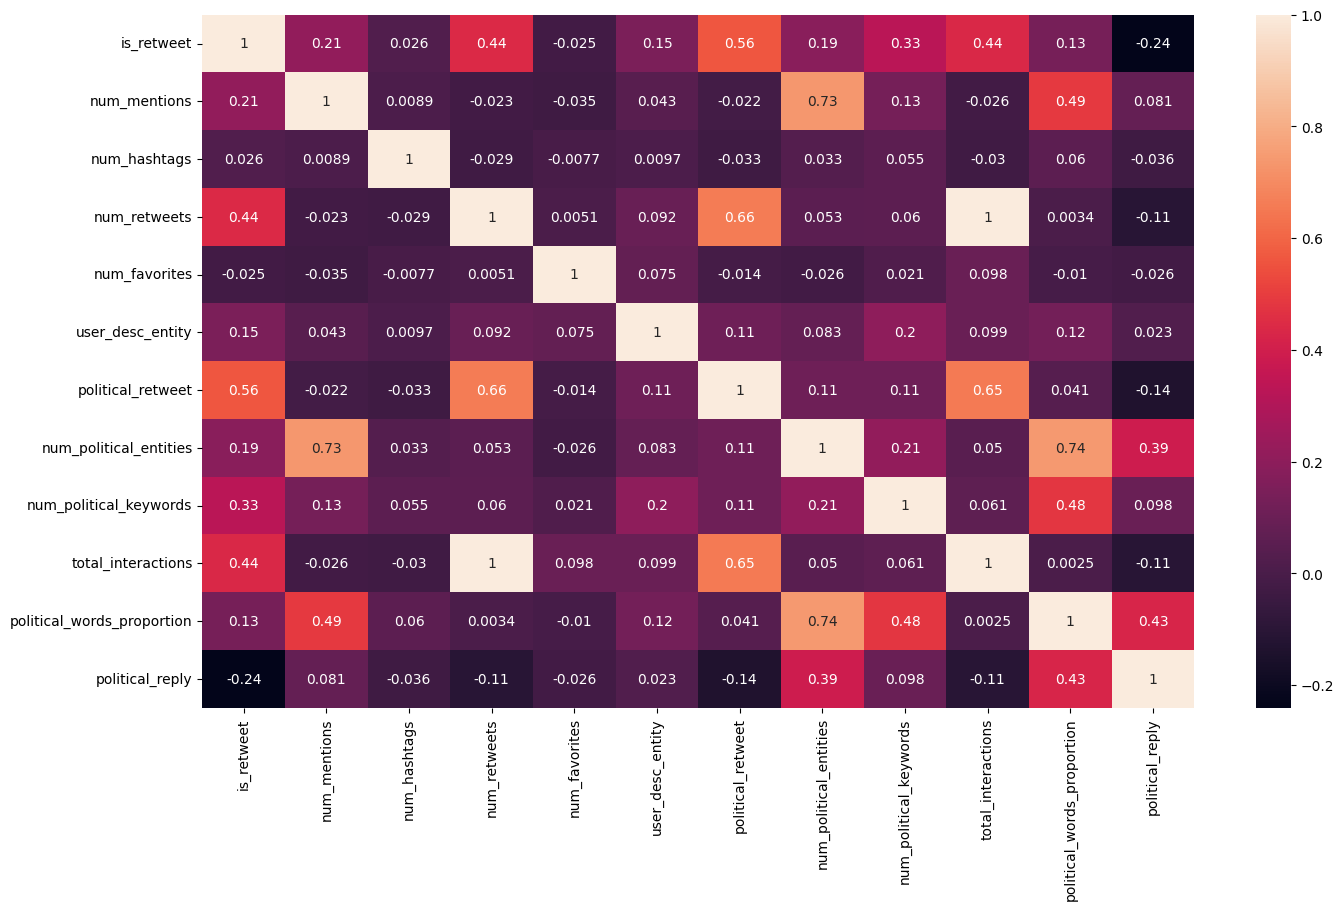

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(dfPoliticalAll_train.drop(['tweet_id', "user_id"], axis = 1).corr(), annot=True)
plt.show()

In [ ]:
dfPoliticalAll_train['isPolitical'].value_counts()

Yes    4123
No     2574
Name: isPolitical, dtype: int64

### 2.1.2. Separate X and y values

In [ ]:
sc = StandardScaler(with_mean = False, with_std = False)

In [ ]:
# Scale the selected features. Features are selected by pre-model training.
dfPoliticalAll_train[["num_retweets","total_interactions","num_political_keywords",
"num_political_entities", "political_words_proportion", "num_hashtags"]] = sc.fit_transform(dfPoliticalAll_train[["num_retweets","total_interactions","num_political_keywords",
                                                            "num_political_entities", "political_words_proportion", "num_hashtags"]])

X_pol_text = dfPoliticalAll_train[["num_retweets", "text", "num_hashtags","total_interactions","num_political_keywords",
"num_political_entities", "political_words_proportion", "annot", "isPolitical"]]

X_pol = dfPoliticalAll_train[["total_interactions","num_political_keywords",
                              "num_political_entities", "political_words_proportion", 
                              "num_retweets", "num_hashtags", "political_reply"]]

y_pol = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1 if x=='Yes' else 0)

### 2.1.3. Train - Validation - Test split

In [ ]:
rs = 210 #Lucky number.

In [ ]:
'''We checked the model performance with cross validation, so splitting data is just nominal. The code
below is just symbolic, you can split the data when training.'''

X_train_pol, X_test_pol, y_train_pol, y_test_pol = train_test_split(X_pol, y_pol, test_size=0.01, random_state=rs, stratify=y_pol)



### 2.1.4. Train the model

##### 2.1.4.1. XGBoost Instance

In [ ]:
# Baseline Model --> Added hashtags, political_reply lowered baseline MSE, 
# need to retune the parameters
xgb_base = xgb.XGBRegressor(
    objective='binary:logistic',
    random_state = rs
)

In [ ]:
# Use cross-validation to evaluate model performance
scores = cross_val_score(xgb_base, X_pol, y_pol, cv=12, scoring='neg_mean_squared_error')

# Print mean and standard deviation of scores
print("Scores:")
print(scores)
print('\nInformation about Scores:')
print("Cross Validation Score (MSE):", np.mean(scores) * -1)
print("STD of CV Scores:", np.std(scores))

Scores:
[-0.067164   -0.0684273  -0.07407021 -0.07737583 -0.0685223  -0.06533178
 -0.07690438 -0.05448103 -0.05900761 -0.05330948 -0.05624899 -0.06996952]

Information about Scores:
Cross Validation Score (MSE): 0.06590103616284486
STD of CV Scores: 0.00806664633142424


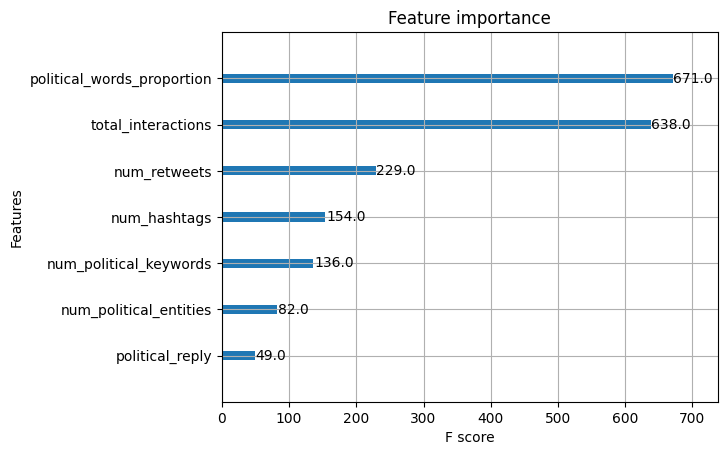

In [ ]:
xgb.plot_importance(xgb_base)
plt.show()

In [ ]:
#Hyperparameter tuning for the model.
params = {
    'max_depth': range(2, 11, 2),
    'min_child_weight':range(1, 6, 2),
    'subsample':[i/10.0 for i in range(5, 11)],
    'colsample_bytree':[i/10.0 for i in range(5, 11)],
    'gamma':[i/10.0 for i in range(6)]
}

tweet_model = GridSearchCV(estimator = xgb_base, param_grid= params, 
                           n_jobs = -1, cv = 5, verbose = 1, 
                           scoring="neg_mean_squared_error")


In [ ]:
print("Best hyperparameters for XGBoost:", tweet_model.best_params_)

Best hyperparameters for XGBoost: {'colsample_bytree': 1.0, 'gamma': 0.3, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1.0}


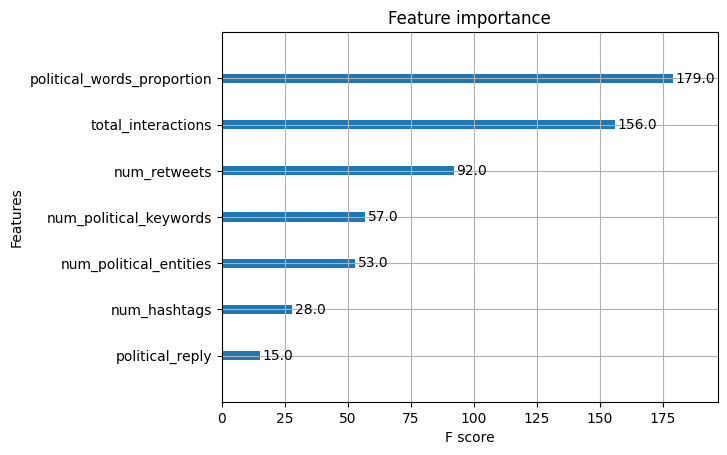

In [ ]:
xgb.plot_importance(tweet_model.best_estimator_)
plt.show()

In [ ]:
# Trial on Optimized Hyperparameters - This parameters came from the GridSearch.

xgb_clf_1 = xgb.XGBRegressor(
    objective='binary:logistic',colsample_bytree= 1, gamma= 0.3, 
    max_depth= 4, min_child_weight= 1, subsample=1, random_state = rs
)



In [ ]:
# Use cross-validation to evaluate model performance
scores = cross_val_score(xgb_clf_1, X_pol, y_pol, cv=12, scoring='neg_mean_squared_error')

# Print mean and standard deviation of scores
print("Scores:")
print(scores)
print('\nInformation about Scores:')
print("Cross Validation Score (MSE):", np.mean(scores) * -1)
print("STD of CV Scores:", np.std(scores))

Scores:
[-0.0646225  -0.06770056 -0.072933   -0.07359052 -0.06810595 -0.062482
 -0.07477347 -0.05481045 -0.05590166 -0.05356295 -0.05301195 -0.0677569 ]

Information about Scores:
Cross Validation Score (MSE): 0.06410432677323452
STD of CV Scores: 0.00771779828200494


In [ ]:
# Hyperparameter tuning of Ege, these parameters adjusted by hand. 
xgb_clf = xgb.XGBRegressor(
        objective='binary:logistic',colsample_bytree= 0.7, gamma= 0.1, 
        max_depth= 2, min_child_weight= 5, subsample=0.9, random_state = rs
)


In [ ]:
# Use cross-validation to evaluate model performance
scores = cross_val_score(xgb_clf, X_pol, y_pol, cv=12, scoring='neg_mean_squared_error')

# Print mean and standard deviation of scores
print("Scores:")
print(scores)
print('\nInformation about Scores:')
print("Cross Validation Score (MSE):", np.mean(scores) * -1)
print("STD of CV Scores:", np.std(scores))

Scores:
[-0.06667161 -0.06927368 -0.07470245 -0.07248573 -0.06698971 -0.06215104
 -0.07596801 -0.05623846 -0.05738868 -0.05575877 -0.05791835 -0.07021551]

Information about Scores:
Cross Validation Score (MSE): 0.06548016695048477
STD of CV Scores: 0.007060965445210106


## 2.2. Bot Detection

In [ ]:
'''This is the cleaned version of user dataset, we used this data in training and testing. This is the same 
data as LabeledUsers_Cleaned in GitHub repository. Users are annotated by authorized people.
This dataframe derived from the metadata with the features above.'''
dfBotAll_train_s = pd.read_csv('dfBotAll_train_n.csv', usecols = lambda x: x != 'Unnamed: 0')
screen_names = list(dfBotAll_train_s['user_screen_name'])
dfBotAll_train = dfBotAll_train[dfBotAll_train['user_screen_name'].isin(screen_names)]

In [ ]:
dfBotAll_train['isBot'].value_counts()

No     5631
Yes     878
Name: isBot, dtype: int64

### 2.2.1. Correlation of Features

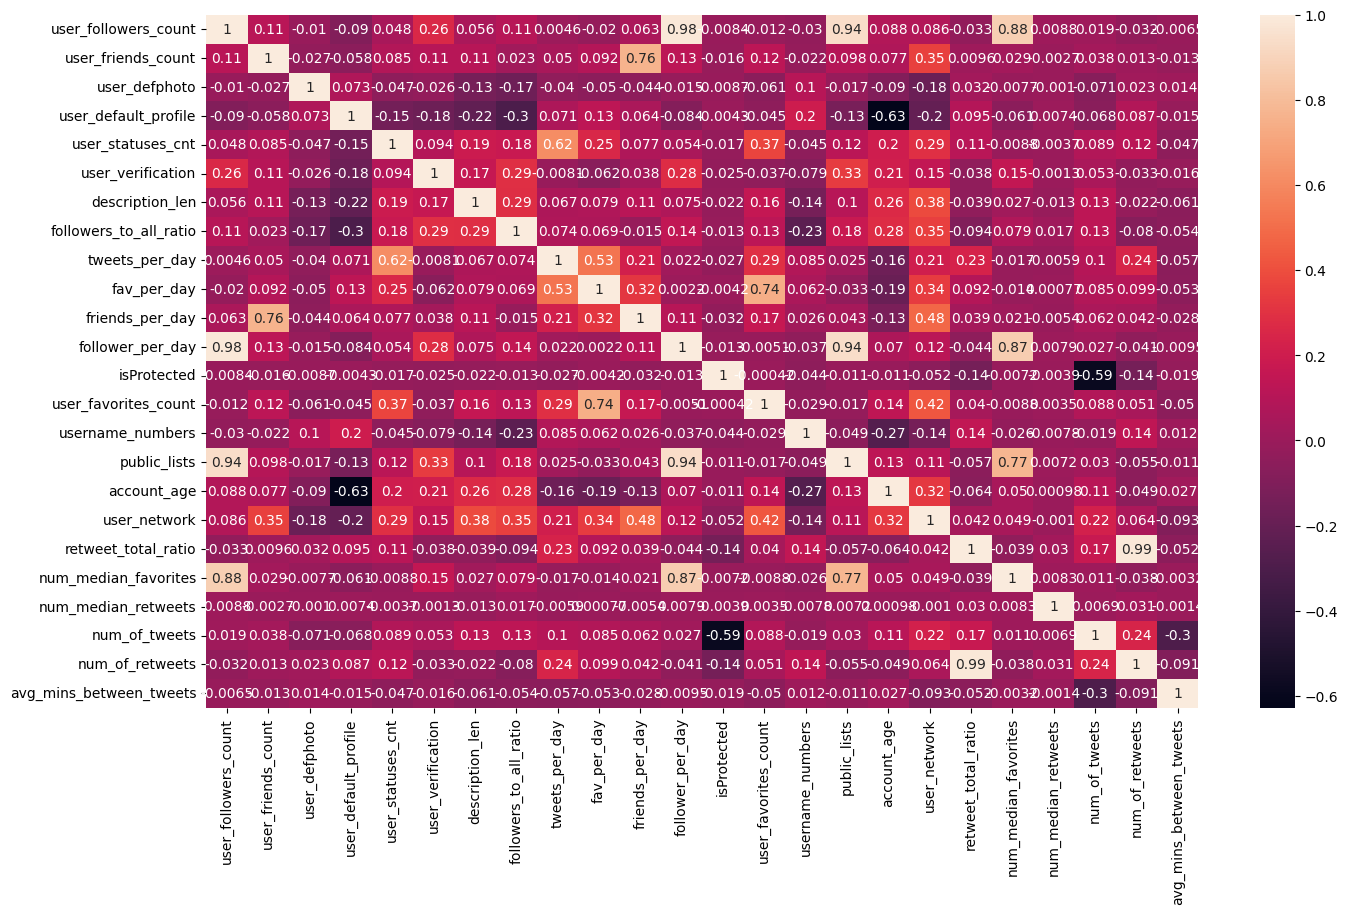

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(dfBotAll_train.drop(['user_id'], axis = 1).corr(), annot=True)
plt.show()

### 2.2.2. Separate X and y values

In [ ]:
dfBotAll_train["user_defphoto"] = dfBotAll_train["user_defphoto"].map({True: 1, False: 0})
dfBotAll_train["user_default_profile"] = dfBotAll_train["user_default_profile"].map({True: 1, False: 0})
dfBotAll_train["user_verification"] = dfBotAll_train["user_verification"].map({True: 1, False: 0})
dfBotAll_train["isProtected"] = dfBotAll_train["isProtected"].map({True: 1, False: 0})

In [ ]:
'''All the features are scaled and features for the model selected by pre-model training.'''
dfBotAll_train[["user_followers_count", "user_friends_count", "user_statuses_cnt", 
                "followers_to_all_ratio","tweets_per_day",  "user_favorites_count", 
                "retweet_total_ratio", "description_len", 'fav_per_day', 'user_network', 
                'follower_per_day','friends_per_day', "username_numbers", "public_lists",
                "account_age", "avg_mins_between_tweets" 
                ]] = sc.fit_transform(dfBotAll_train[[
                "user_followers_count", "user_friends_count", 
                "user_statuses_cnt", "followers_to_all_ratio",
                "tweets_per_day",  "user_favorites_count",
                "retweet_total_ratio", 'description_len' ,'fav_per_day',
                'user_network', 'follower_per_day','friends_per_day', "username_numbers", "public_lists",
                "account_age", "avg_mins_between_tweets" ]])

X_bot = dfBotAll_train[["user_followers_count", "user_friends_count", 
                "user_statuses_cnt", "followers_to_all_ratio",
                "tweets_per_day", "user_favorites_count",
                "retweet_total_ratio", 'description_len' ,'fav_per_day',
                'user_network', 'follower_per_day','friends_per_day',
                "account_age", "avg_mins_between_tweets",
                "user_verification"]]

X_bot_user = dfBotAll_train[["user_screen_name", "isBot", "annot"]]
                    
y_bot = dfBotAll_train.isBot.apply(lambda x: 1 if x=='Yes' else 0)

/tmp/ipykernel_183/67640005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfBotAll_train[["user_followers_count", "user_friends_count", "user_statuses_cnt",
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


### 2.2.3. Train-test split

In [ ]:
'''We checked the model performance with cross validation, so splitting data is just nominal.
The code is ready for splitting, you can split it if you wish.'''
X_train_bot, X_test_bot, y_train_bot, y_test_bot = train_test_split(X_bot, y_bot, test_size=0.001, random_state=rs, stratify=y_bot)

### 2.2.4. Train the model

In [ ]:
xgb_base_bot = xgb.XGBRegressor(
    objective='binary:logistic', 
    random_state = rs
)


In [ ]:
# Use cross-validation to evaluate model performance
scores = cross_val_score(xgb_base_bot, X_bot, y_bot, cv=12, scoring='neg_mean_squared_error')

# Print mean and standard deviation of scores
print("Scores:")
print(scores)
print('\nInformation about Scores:')
print("Cross Validation Score (MSE):", np.mean(scores) * -1)
print("STD of CV Scores:", np.std(scores))

Scores:
[-0.0894356  -0.09336096 -0.07371158 -0.09956602 -0.08567288 -0.09761695
 -0.08729789 -0.07482174 -0.07171416 -0.10200534 -0.06406929 -0.09037326]

Information about Scores:
Cross Validation Score (MSE): 0.08580380431395535
STD of CV Scores: 0.011628282760270135


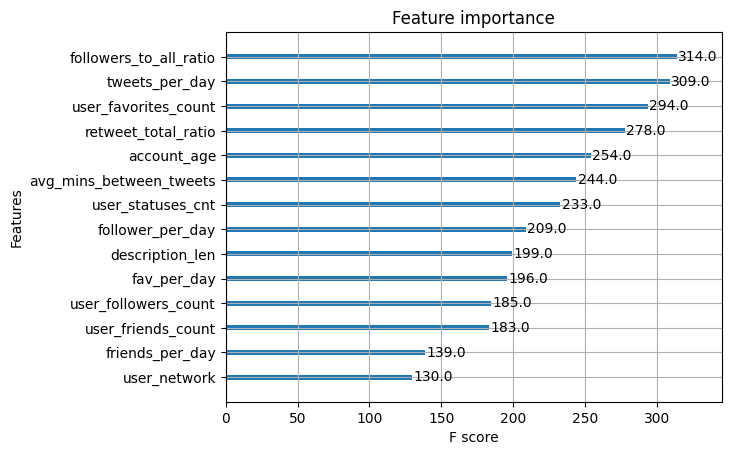

In [ ]:
xgb.plot_importance(xgb_base_bot)
plt.show()

In [ ]:
# Ege's hyperparameter tuning by hand, this parameters adjusted manually.
xgb_bot = xgb.XGBRegressor(
    objective='binary:logistic',colsample_bytree= 0.7, gamma= 0.1, 
    max_depth= 2, min_child_weight= 5, subsample=0.9, random_state = rs
)


In [ ]:
# Use cross-validation to evaluate model performance
scores = cross_val_score(xgb_bot, X_bot, y_bot, cv=12, scoring='neg_mean_squared_error')

# Print mean and standard deviation of scores
print("Scores:")
print(scores)
print('\nInformation about Scores:')
print("Cross Validation Score (MSE):", np.mean(scores) * -1)
print("STD of CV Scores:", np.std(scores))

Scores:
[-0.07663252 -0.08022458 -0.07031075 -0.09428378 -0.08303517 -0.09152897
 -0.07920072 -0.06803463 -0.06392035 -0.08990151 -0.06407044 -0.07979568]

Information about Scores:
Cross Validation Score (MSE): 0.07841159087815107
STD of CV Scores: 0.009896749412400506


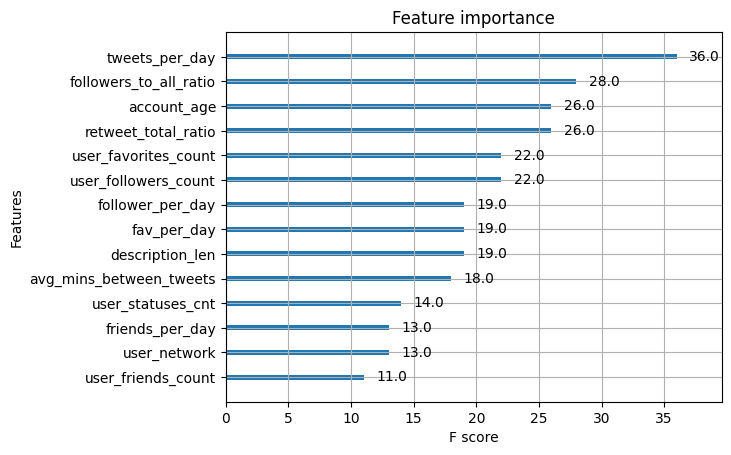

In [ ]:
xgb.plot_importance(xgb_bot)
plt.show()

In [ ]:
# Hyperparameter tuning with GridSearch.
params = {
    'max_depth': range(2, 11, 2),
    'min_child_weight':range(1, 6, 2),
    'subsample':[i/10.0 for i in range(5, 11)],
    'colsample_bytree':[i/10.0 for i in range(5, 11)],
    'gamma':[i/10.0 for i in range(6)]
}

# grid search the model
xgb_bot_model = GridSearchCV(estimator = xgb_base_bot, param_grid= params, 
                           n_jobs = -1, cv = 5, verbose = 1, 
                           scoring="neg_mean_squared_error")


In [ ]:
print("Best parameters for XGBoost:", xgb_bot_model.best_params_)

Best parameters for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0.2, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 1.0}


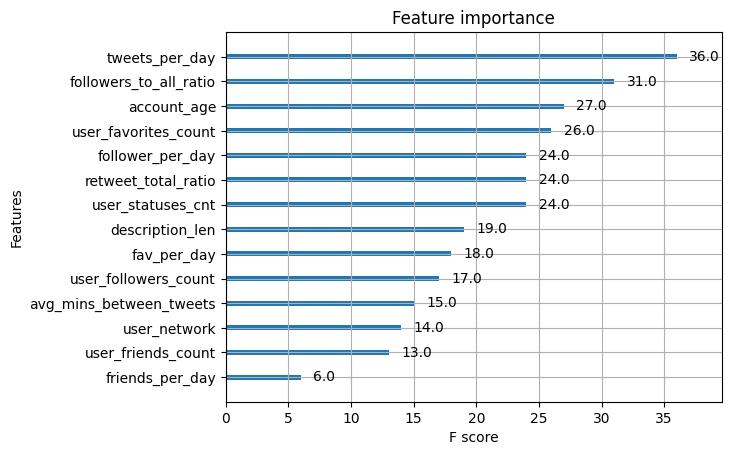

In [ ]:
xgb.plot_importance(xgb_bot_model.best_estimator_)
plt.show()

In [ ]:
# Parameters from GridSearch.
xgb_bot_2 = xgb.XGBRegressor(
    objective='binary:logistic',colsample_bytree= 0.8, gamma= 0.4, 
    max_depth= 2, min_child_weight= 1, subsample=0.8, random_state = rs
)


In [ ]:
# Use cross-validation to evaluate model performance
scores = cross_val_score(xgb_bot_2, X_bot, y_bot, cv=12, scoring='neg_mean_squared_error')

# Print mean and standard deviation of scores
print("Scores:")
print(scores)
print('\nInformation about Scores:')
print("Cross Validation Score (MSE):", np.mean(scores) * -1)
print("STD of CV Scores:", np.std(scores))

Scores:
[-0.07611777 -0.07824593 -0.07056535 -0.09273154 -0.07895111 -0.09524829
 -0.08252911 -0.06497824 -0.06531028 -0.09211751 -0.06596447 -0.08208123]

Information about Scores:
Cross Validation Score (MSE): 0.07873673704352328
STD of CV Scores: 0.010326796229907093


<center><span style="color:#606c38;font-weight:700;font-size:15px;">
Evaluation
    </span></center>

<span><center> Both models were successful on the identified problem, approaching the 0.07~ MSE score. Improvements can be made for future work. Political tweet prediction can be adapted to different countries by changing actors. For bot prediction, the above model is insufficient to make inferences from the user's tweets. In future studies, tweets can be further integrated into the model by analyzing the tweets of bots over tweet text.